__Imports__

In [1]:
!pip install transformers

import os
import shutil
import copy
import random
from glob import glob
import sys
import re

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models.swin_transformer import Swin_V2_T_Weights, Swin_V2_B_Weights
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.init as init
from torchvision.transforms import ToTensor, ToPILImage
import torchvision.transforms.functional as TF

from transformers import set_seed, AutoImageProcessor, AutoModelForImageClassification, get_cosine_schedule_with_warmup
from PIL import Image, ImageOps, ImageEnhance

from tqdm import tqdm

import pickle

import zipfile

from google.colab import drive, files

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, f1_score, top_k_accuracy_score

drive.mount('/content/gdrive')

Mounted at /content/gdrive


__Utility Functions__

In [2]:
class CustomTransforms:
    def __init__(self):
        self.size = 192
        self.mean_rgb = [0.5, 0.5, 0.5]
        self.std_rgb = [0.5, 0.5, 0.5]
        self.mean_depth = [0.5, 0.5, 0.5]
        self.std_depth = [0.5, 0.5, 0.5]
        #self.mean_rgb = [0.485, 0.456, 0.406]
        #self.std_rgb = [0.229, 0.224, 0.225]
        #self.mean_depth = [0.485, 0.456, 0.406]
        #self.std_depth = [0.229, 0.224, 0.225]
        self.augmentation_list = [
            self.identity,
            self.autocontrast,
            self.equalize,
            self.rotate,
            self.solarize,
            self.color,
            self.contrast,
            self.brightness,
            self.sharpness
        ]

    def int_parameter(self, level, maxval):
        return int(level * maxval / 10)

    def float_parameter(self, level, maxval):
        return float(level * maxval / 10)

    def identity(self, img, severity=1):
        return img

    def autocontrast(self, img, severity=1):
        return ImageOps.autocontrast(img)

    def equalize(self, img, severity=1):
        return ImageOps.equalize(img)

    def rotate(self, img, severity=1):
        degrees = self.int_parameter(severity, 30)
        if random.random() < 0.5:
            degrees = -degrees
        return img.rotate(degrees, resample=Image.BILINEAR)

    def solarize(self, img, severity=1):
        threshold = 256 - self.int_parameter(severity, 128)
        return ImageOps.solarize(img, threshold)

    def color(self, img, severity=1):
        factor = self.float_parameter(severity, 1.8) + 0.1
        return ImageEnhance.Color(img).enhance(factor)

    def contrast(self, img, severity=1):
        factor = self.float_parameter(severity, 1.8) + 0.1
        return ImageEnhance.Contrast(img).enhance(factor)

    def brightness(self, img, severity=1):
        factor = self.float_parameter(severity, 1.8) + 0.1
        return ImageEnhance.Brightness(img).enhance(factor)

    def sharpness(self, img, severity=1):
        factor = self.float_parameter(severity, 1.8) + 0.1
        return ImageEnhance.Sharpness(img).enhance(factor)

    def synchronized_augmix(self, rgb_image, depth_image, severity=3, width=3, depth=-1, alpha=1.0):
        ws = np.float32(np.random.dirichlet([alpha] * width))
        m = np.float32(np.random.beta(alpha, alpha))

        rgb_mix = np.zeros_like(np.array(rgb_image), dtype=np.float32)
        depth_mix = np.zeros_like(np.array(depth_image), dtype=np.float32)

        for i in range(width):
            rgb_image_aug = rgb_image.copy()
            depth_image_aug = depth_image.copy()

            depth_chain = depth if depth > 0 else np.random.randint(1, 4)
            for _ in range(depth_chain):
                op = np.random.choice(self.augmentation_list)
                rgb_image_aug = op(rgb_image_aug, severity)
                depth_image_aug = op(depth_image_aug, severity)

            rgb_mix += ws[i] * np.array(rgb_image_aug, dtype=np.float32)
            depth_mix += ws[i] * np.array(depth_image_aug, dtype=np.float32)

        rgb_mixed = (1 - m) * np.array(rgb_image, dtype=np.float32) + m * rgb_mix
        depth_mixed = (1 - m) * np.array(depth_image, dtype=np.float32) + m * depth_mix

        return Image.fromarray(np.uint8(rgb_mixed)), Image.fromarray(np.uint8(depth_mixed))

    def random_resized_crop(self, rgb_image, depth_image):
        i, j, h, w = transforms.RandomResizedCrop.get_params(rgb_image, scale=(0.7, 1.0), ratio=(1.0, 1.0))
        rgb_image = TF.resized_crop(rgb_image, i, j, h, w, size=(self.size, self.size), antialias=True)
        depth_image = TF.resized_crop(depth_image, i, j, h, w, size=(self.size, self.size), antialias=True)
        return rgb_image, depth_image

    def random_horizontal_flip(self, rgb_image, depth_image):
        if random.random() > 0.5:
            rgb_image = TF.hflip(rgb_image)
            depth_image = TF.hflip(depth_image)
        return rgb_image, depth_image

    def to_tensor_and_normalize(self, rgb_image, depth_image):
        rgb_image = TF.to_tensor(rgb_image)
        depth_image = TF.to_tensor(depth_image)
        rgb_image = TF.normalize(rgb_image, mean=self.mean_rgb, std=self.std_rgb)
        depth_image = TF.normalize(depth_image, mean=self.mean_depth, std=self.std_depth)
        return rgb_image, depth_image

    def normalize_tensors(self, rgb_tensor, depth_tensor):
        rgb_tensor = TF.normalize(rgb_tensor, mean=self.mean_rgb, std=self.std_rgb)
        # no need to normalize metric depth data
        #depth_tensor = TF.normalize(depth_tensor, mean=self.mean_depth, std=self.std_depth)
        return rgb_tensor, depth_tensor

    def random_greyscale(self, rgb_image, depth_image):
        if random.random() > 0.1:
            rgb_image = TF.to_grayscale(rgb_image, num_output_channels=3)
            depth_image = TF.to_grayscale(depth_image, num_output_channels=3)
        return rgb_image, depth_image

    def random_greyscale_tensors(self, rgb_tensor, depth_tensor):
        if random.random() > 0.1:
            rgb_tensor = TF.rgb_to_grayscale(rgb_tensor, num_output_channels=3)
            depth_tensor = TF.rgb_to_grayscale(depth_tensor, num_output_channels=3)
        return rgb_tensor, depth_tensor

    def synchronized_transform_train_ch(self, rgb_image, depth_image):
        rgb_image, depth_image = self.random_resized_crop(rgb_image, depth_image)
        rgb_image, depth_image = self.random_horizontal_flip(rgb_image, depth_image)
        # ColorJitter (only for RGB)
        color_jitter = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3)
        rgb_image = color_jitter(rgb_image)
        rgb_image, depth_image = self.random_greyscale(rgb_image, depth_image)
        return self.to_tensor_and_normalize(rgb_image, depth_image)

    def synchronized_transform_train_ft(self, rgb_image, depth_image):
        rgb_image, depth_image = self.random_resized_crop(rgb_image, depth_image)
        rgb_image, depth_image = self.random_horizontal_flip(rgb_image, depth_image)
        rgb_image, depth_image = self.synchronized_augmix(rgb_image, depth_image)
        return self.to_tensor_and_normalize(rgb_image, depth_image)

    def synchronized_transform_val(self, rgb_image, depth_image):
        rgb_image = TF.resize(rgb_image, size=(self.size, self.size), antialias=True)
        depth_image = TF.resize(depth_image, size=(self.size, self.size), antialias=True)
        return self.to_tensor_and_normalize(rgb_image, depth_image)

    def synchronized_transform_train_ch_metric(self, rgb_image, depth_tensor):
        color_jitter = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3)
        rgb_image = color_jitter(rgb_image)
        rgb_tensor = TF.to_tensor(rgb_image)
        rgb_tensor, depth_tensor = self.random_resized_crop(rgb_tensor, depth_tensor)
        rgb_tensor, depth_tensor = self.random_horizontal_flip(rgb_tensor, depth_tensor)
        rgb_tensor, depth_tensor = self.random_greyscale_tensors(rgb_tensor, depth_tensor)
        return self.normalize_tensors(rgb_tensor, depth_tensor)

    def synchronized_transform_train_ft_metric(self, rgb_image, depth_tensor):
        rgb_tensor = TF.to_tensor(rgb_image)
        rgb_tensor, depth_tensor = self.random_resized_crop(rgb_tensor, depth_tensor)
        rgb_tensor, depth_tensor = self.random_horizontal_flip(rgb_tensor, depth_tensor)
        # Skipping synchronized_augmix as it's complex to adapt for tensors and most of it only applies to rgb data not depth data (colorization etc.)
        return self.normalize_tensors(rgb_tensor, depth_tensor)

    def synchronized_transform_val_metric(self, rgb_image, depth_tensor):
        rgb_tensor = TF.to_tensor(rgb_image)
        rgb_tensor = TF.resize(rgb_tensor, size=(self.size, self.size), antialias=True)
        depth_tensor = TF.resize(depth_tensor, size=(self.size, self.size), antialias=True)
        return self.normalize_tensors(rgb_tensor, depth_tensor)


class CustomImageDataset(Dataset):
    def __init__(self, rgb_folder_path, depth_folder_path, processor=None, transform=None):
        self.rgb_folder_path = rgb_folder_path
        self.depth_folder_path = depth_folder_path
        self.processor = processor
        self.transform = transform

        self.image_paths = []
        self.labels = []
        self.label_mapping = {}
        self.reverse_label_mapping = {}

        class_dirs = sorted([d for d in os.listdir(self.rgb_folder_path) if os.path.isdir(os.path.join(self.rgb_folder_path, d))])
        for label, class_dir in enumerate(class_dirs):
            self.label_mapping[class_dir] = label
            self.reverse_label_mapping[label] = class_dir

            rgb_class_path = os.path.join(self.rgb_folder_path, class_dir)
            depth_class_path = os.path.join(self.depth_folder_path, class_dir)
            rgb_filenames = sorted(os.listdir(rgb_class_path))
            depth_filenames = sorted(os.listdir(depth_class_path))

            valid_extensions = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.pt')
            for rgb_filename, depth_filename in zip(os.listdir(rgb_class_path), os.listdir(depth_class_path)):
                if rgb_filename.lower().endswith(valid_extensions) and depth_filename.lower().endswith(valid_extensions):
                   rgb_image_path = os.path.join(rgb_class_path, rgb_filename)
                   depth_image_path = os.path.join(depth_class_path, depth_filename)
                   self.image_paths.append((rgb_image_path, depth_image_path))
                   self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        rgb_image_path, depth_image_path = self.image_paths[idx]
        rgb_inputs = Image.open(rgb_image_path).convert('RGB')
        label = self.labels[idx]
        if "/data_depth_metric/" in self.depth_folder_path:
            depth_inputs = torch.load(depth_image_path)
            depth_inputs = depth_inputs.unsqueeze(0)
            depth_inputs = depth_inputs.repeat(3, 1, 1)
            rgb_inputs, depth_inputs = self.transform(rgb_inputs, depth_inputs)
        else:
            depth_inputs_prelim = Image.open(depth_image_path).convert('L')
            depth_inputs = Image.new('RGB', depth_inputs_prelim.size)
            depth_inputs.paste(depth_inputs_prelim, (0, 0, depth_inputs_prelim.width, depth_inputs_prelim.height))
            if self.transform:
                rgb_inputs, depth_inputs = self.transform(rgb_inputs, depth_inputs)
            if self.processor:
                rgb_inputs = self.processor(images=rgb_inputs, return_tensors="pt", do_normalize=True, do_rescale=True, do_resize=True)
                depth_inputs = self.processor(images=depth_inputs, return_tensors="pt", do_normalize=True, do_rescale=True, do_resize=True)
                rgb_inputs = {'pixel_values': rgb_inputs['pixel_values'][0], 'labels': torch.tensor(label)}
                depth_inputs = {'pixel_values': depth_inputs['pixel_values'][0], 'labels': torch.tensor(label)}
                return rgb_inputs, depth_inputs, rgb_image_path
        rgb_inputs = {'pixel_values': rgb_inputs, 'labels': torch.tensor(label)}
        depth_inputs = {'pixel_values': depth_inputs, 'labels': torch.tensor(label)}
        return rgb_inputs, depth_inputs, rgb_image_path

    def get_class_name(self, label):
        return self.reverse_label_mapping[label]


class EnsembleModel(nn.Module):
    def __init__(self, model_rgb, model_depth, model_rgbd_classifier):
        super(EnsembleModel, self).__init__()

        self.model_rgb = model_rgb
        self.model_depth = model_depth
        self.model_rgbd_classifier = model_rgbd_classifier
        self.model_rgbd_classifier.classifier = nn.Linear(in_features=1024*2, out_features=102, bias=True)
        self.model_rgbd_classifier = list(self.model_rgbd_classifier.children())[-1]
        self.hook_output_rgb = None
        self.hook_output_depth = None
        self.model_rgb.swinv2.pooler.register_forward_hook(self.hook_fn_rgb)
        self.model_depth.swinv2.pooler.register_forward_hook(self.hook_fn_depth)

    def hook_fn_rgb(self, module, input, output):
        self.hook_output_rgb = output

    def hook_fn_depth(self, module, input, output):
        self.hook_output_depth = output

    def forward(self, pixel_values_rgb, pixel_values_depth):
        _ = self.model_rgb(pixel_values=pixel_values_rgb)
        _ = self.model_depth(pixel_values=pixel_values_depth)
        x1 = self.hook_output_rgb.squeeze(-1)
        x2 = self.hook_output_depth.squeeze(-1)
        x = torch.cat((x1, x2), dim=1)
        out = self.model_rgbd_classifier(x)
        return out


__Helper Functions__

In [3]:
def load_pickle_data(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

def load_ensemble_model(save_path, model_rgb, model_depth, model_rgbd_classifier):
    ensemble_model = EnsembleModel(model_rgb, model_depth, model_rgbd_classifier)
    model_save_dict = torch.load(save_path)
    ensemble_model.model_rgb.load_state_dict(model_save_dict['model_rgb_state_dict'])
    ensemble_model.model_depth.load_state_dict(model_save_dict['model_depth_state_dict'])
    ensemble_model.model_rgbd_classifier.load_state_dict(model_save_dict['model_rgbd_classifier_state_dict'])
    return ensemble_model


def test_model(model, test_dataloader, dataset):
    model.eval()
    all_outputs = []
    all_labels = []
    all_filenames = []
    correct_filenames_by_class_name = {}

    with torch.no_grad():
        for (batch_rgb, batch_depth, file_paths) in test_dataloader:
            inputs_rgb = batch_rgb['pixel_values'].to(DEVICE)
            inputs_depth = batch_depth['pixel_values'].to(DEVICE)
            targets = batch_rgb['labels'].to(DEVICE)

            outputs = model(pixel_values_rgb=inputs_rgb, pixel_values_depth=inputs_depth)

            all_outputs.append(outputs)
            all_labels.append(targets)
            all_filenames.extend(file_paths)

    all_outputs = torch.cat(all_outputs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    _, predictions = all_outputs.max(1)
    for i in range(len(all_labels)):
        actual_class_name = dataset.get_class_name(all_labels[i].item())
        predicted_class_name = dataset.get_class_name(predictions[i].item())
        if actual_class_name == predicted_class_name:
            if actual_class_name not in correct_filenames_by_class_name:
                correct_filenames_by_class_name[actual_class_name] = []
            correct_filenames_by_class_name[actual_class_name].append(all_filenames[i])


    _, predictions = all_outputs.max(1)
    correct = (predictions == all_labels).sum().item()
    total = all_labels.size(0)
    accuracy = 100 * correct / total

    all_labels_cpu = all_labels.cpu()
    predictions_cpu = predictions.cpu()
    balanced_acc = 100 * balanced_accuracy_score(all_labels_cpu.numpy(), predictions_cpu.numpy())
    f1_macro = 100 * f1_score(all_labels_cpu.numpy(), predictions_cpu.numpy(), average='macro')

    return all_outputs, all_labels, accuracy, balanced_acc, f1_macro, correct_filenames_by_class_name

__Orchestration Code__

Load Data

In [4]:
directory_path = "/content/gdrive/MyDrive/Masterarbeit/data"
new_directory_path = "/content/"

folder = ""
for i in os.listdir(directory_path):
  if i.endswith('.zip'):
    zip_file_path = os.path.join(directory_path, i)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        extract_folder = os.path.join(new_directory_path, i.split('.zip')[0])
        zip_ref.extractall(extract_folder)
        folder = i.split('.zip')[0]

  folder_path = os.path.join(new_directory_path, folder)
  macosx_path = os.path.join(folder_path, "__MACOSX")
  if os.path.exists(macosx_path):
      shutil.rmtree(macosx_path)

In [17]:
#Normalized Depth CustomTransforms
#test_dataset = CustomImageDataset(rgb_folder_path='/content/data_rgb/test', depth_folder_path='/content/data_depth/test', processor=None, transform=CustomTransforms().synchronized_transform_val)

#Normalized Depth AutoImageProcessor
#processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-base-patch4-window12-192-22k")
#test_dataset = CustomImageDataset(rgb_folder_path='/content/data_rgb/test', depth_folder_path='/content/data_depth/test', processor=processor, transform=None)

#Metric Depth
test_dataset = CustomImageDataset(rgb_folder_path='/content/data_rgb/test', depth_folder_path='/content/data_depth_metric/test', processor=None, transform=CustomTransforms().synchronized_transform_val_metric)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Load Model

In [18]:
file_path_in_drive = "/content/gdrive/MyDrive/Masterarbeit/models/best_models/best_model_latefusion_ch_ft_metric_depth.pt"
#file_path_in_drive = "/content/gdrive/MyDrive/Masterarbeit/models/best_models/best_model_latefusion_ch_metric_depth.pt"
#file_path_in_drive = "/content/gdrive/MyDrive/Masterarbeit/models/best_models/best_model_latefusion_ch_ft_normalized_depth.pt"
#file_path_in_drive = "/content/gdrive/MyDrive/Masterarbeit/models/best_models/best_model_latefusion_ch_autoimageprocessor_normalized_depth.pt"
#file_path_in_drive = "/content/gdrive/MyDrive/Masterarbeit/models/best_models/best_model_latefusion_ch_customtransforms_normalized_depth.pt"
#file_path_in_drive = "/content/gdrive/MyDrive/Masterarbeit/models/best_models/best_model_earlyfusion_ch_ft_normalized_depth.pt"
#file_path_in_drive = "/content/gdrive/MyDrive/Masterarbeit/models/best_models/best_model_earlyfusion_ch_customtransforms_normalized_depth.pt"


local_file_path = '/content/model.pt'
shutil.copy(file_path_in_drive, local_file_path)

DEVICE = torch.device("cuda:0")

saved_model_path = "/content/model.pt"

base_model_swin_rgb = AutoModelForImageClassification.from_pretrained("microsoft/swinv2-base-patch4-window12-192-22k", num_labels=102, ignore_mismatched_sizes=True)
base_model_swin_depth = AutoModelForImageClassification.from_pretrained("microsoft/swinv2-base-patch4-window12-192-22k", num_labels=102, ignore_mismatched_sizes=True)
classifier_model_swin_rgbd = AutoModelForImageClassification.from_pretrained("microsoft/swinv2-base-patch4-window12-192-22k", num_labels=102, ignore_mismatched_sizes=True)

ensemble_model = EnsembleModel(base_model_swin_rgb, base_model_swin_depth, classifier_model_swin_rgbd)

model_save_dict = torch.load(saved_model_path)

ensemble_model.model_rgb.load_state_dict(model_save_dict['model_rgb_state_dict'])
ensemble_model.model_depth.load_state_dict(model_save_dict['model_depth_state_dict'])
ensemble_model.model_rgbd_classifier.load_state_dict(model_save_dict['model_rgbd_classifier_state_dict'])

loaded_model = ensemble_model.to(DEVICE)

all_outputs, all_labels, accuracy, balanced_acc, f1_macro, correct_filenames_by_class_name = test_model(loaded_model, test_loader, test_dataset)

print(f"Model Results: ")
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Test Balanced Accuracy: {balanced_acc:.2f}%")
print(f"Test F1-Macro: {f1_macro:.2f}%")

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window12-192-22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1024]) in the checkpoint and torch.Size([102, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([102]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window12-192-22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1024]) in the checkpoint and torch.Size([102, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([102]) in the model inst

Model Results: 
Test Accuracy: 69.83%
Test Balanced Accuracy: 70.46%
Test F1-Macro: 67.02%


In [ ]:
file_path_in_drive = "/content/gdrive/MyDrive/Masterarbeit/models/results/best_model_latefusion_ch_ft_metric_depth_results.pkl"
local_file_path = '/content/results.pkl'
shutil.copy(file_path_in_drive, local_file_path)
saved_results_path = "/content/results.pkl"

results_data = load_pickle_data(local_file_path)

all_outputs_ = results_data['all_outputs']
all_labels_ = results_data['all_labels']
accuracy_ = results_data['accuracy']
balanced_acc_ = results_data['balanced_acc']
f1_macro_ =  results_data['f1_macro']

__Confusion Matrix__

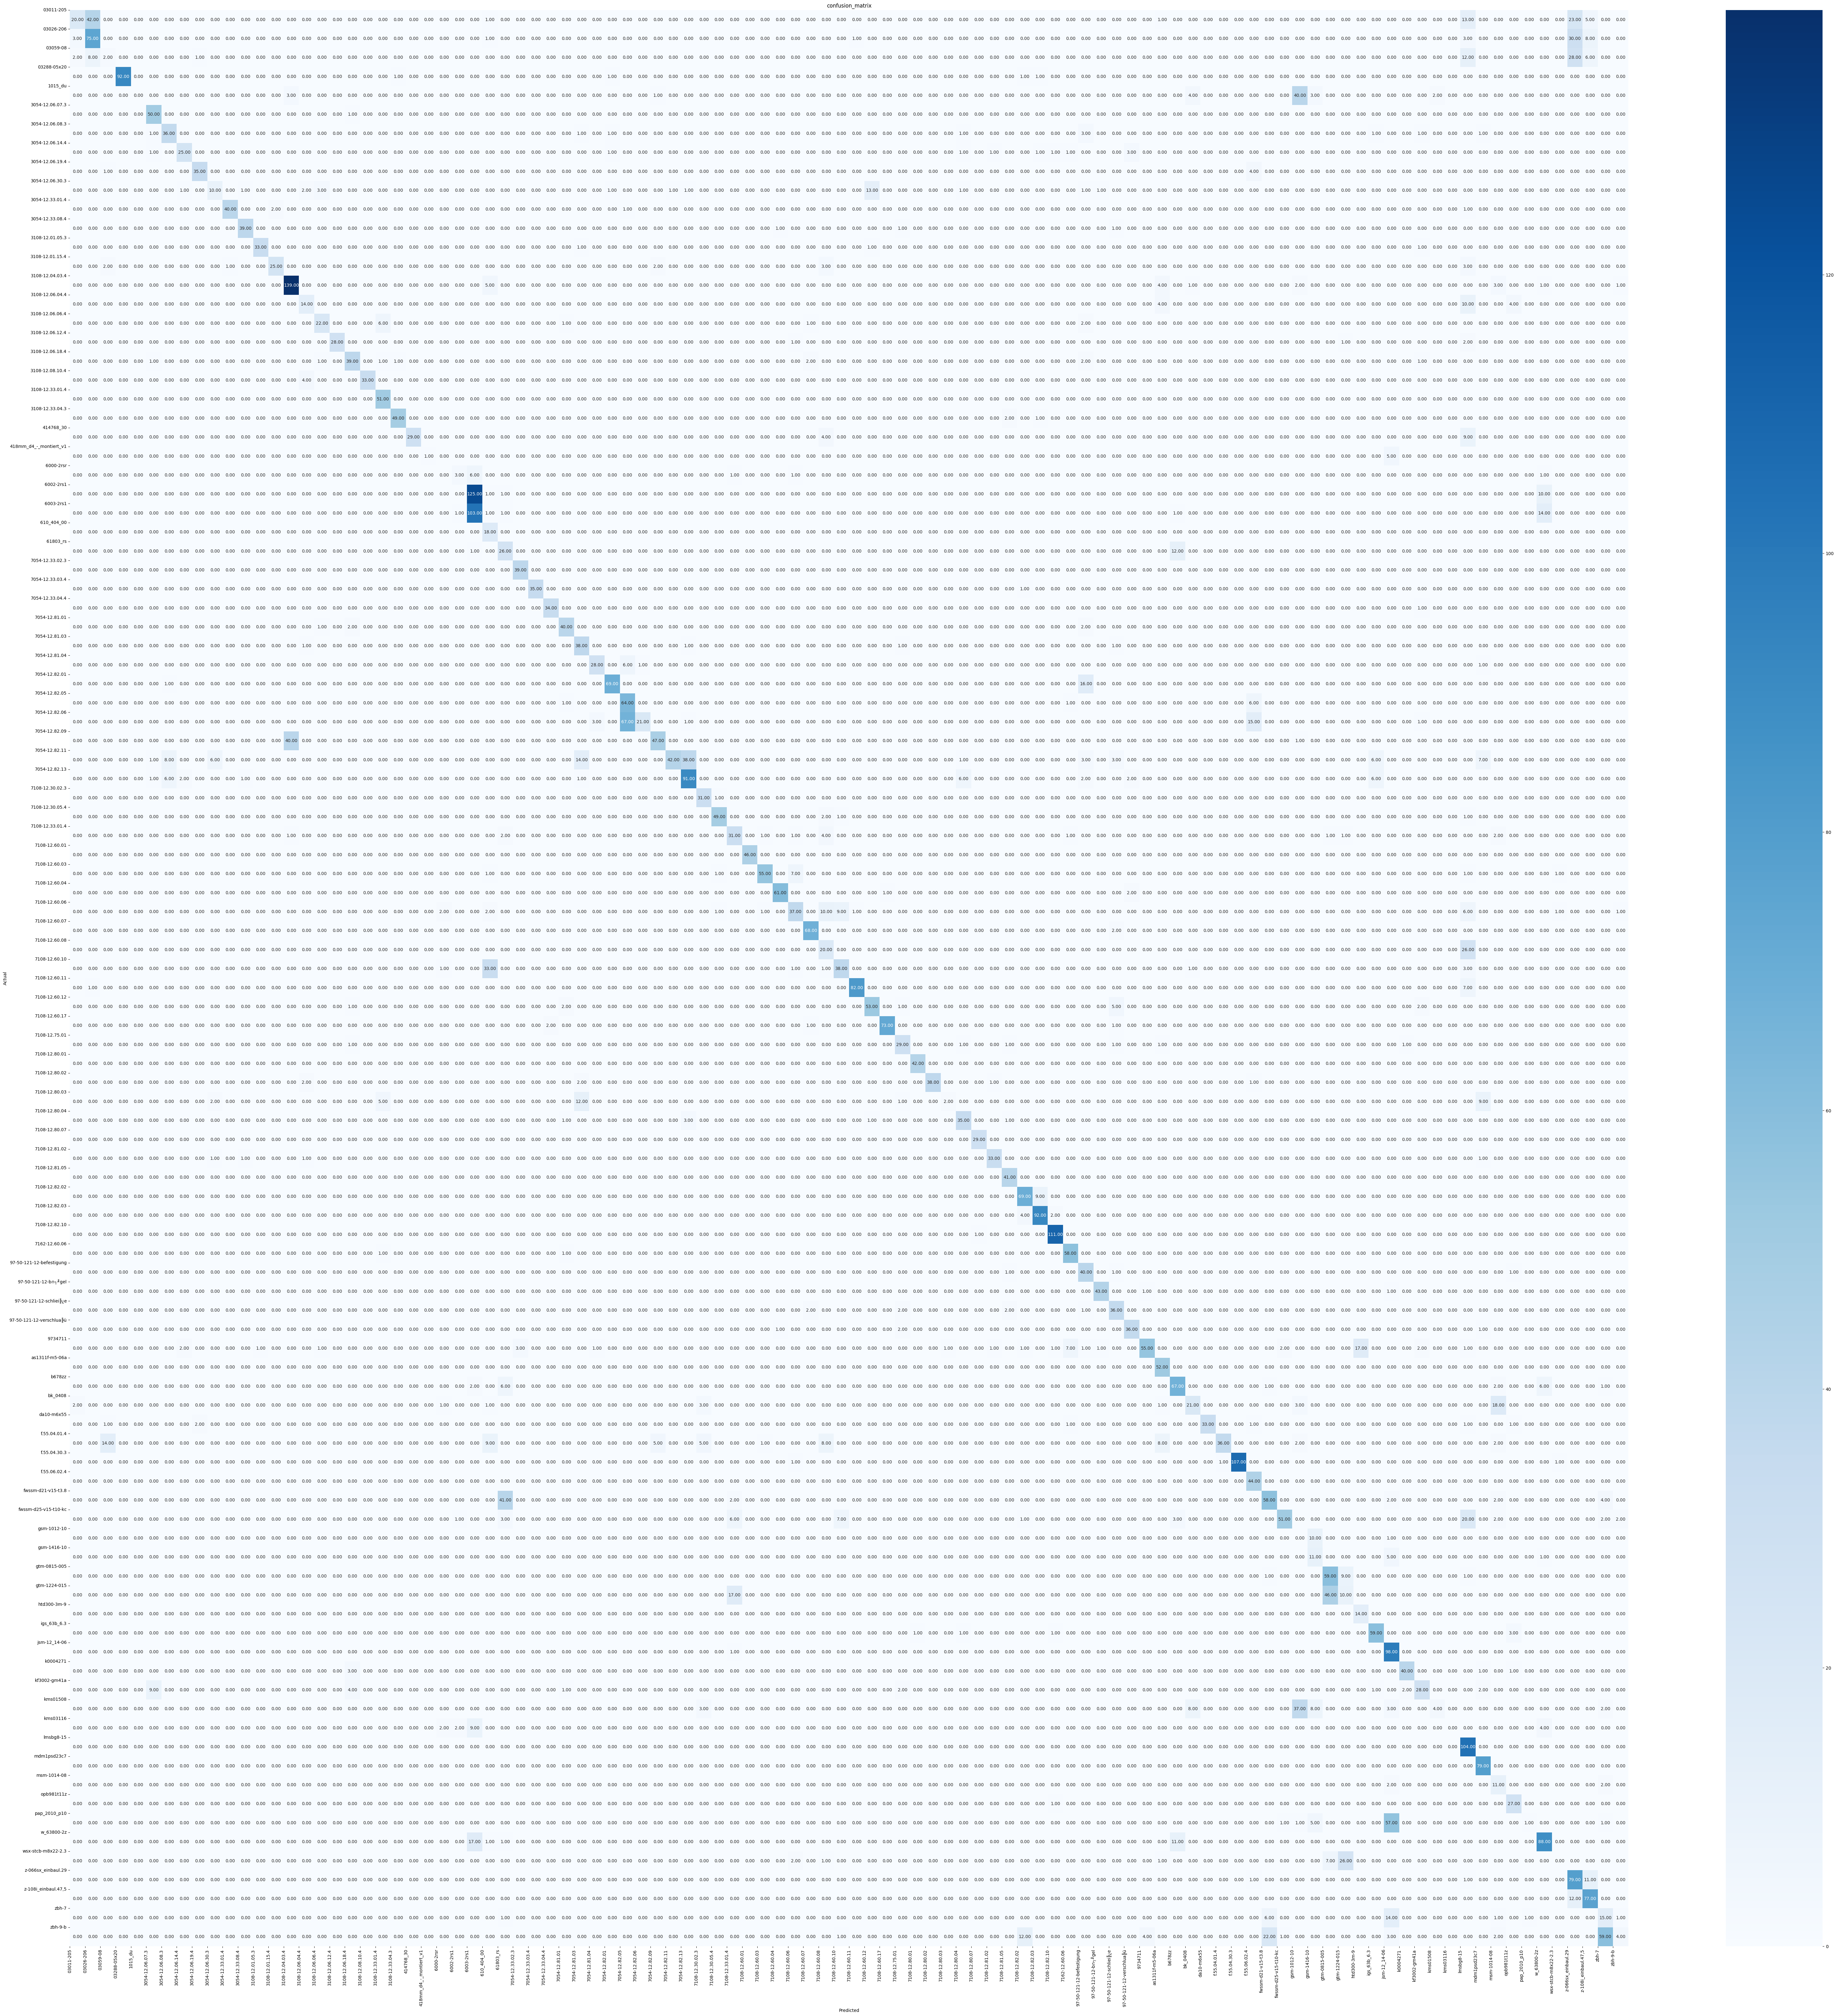

In [19]:
num_classes = len(np.unique(all_labels.cpu().numpy()))
class_names = [test_dataset.get_class_name(i) for i in range(num_classes)]
predicted_labels = torch.max(all_outputs, 1)[1]
cm = confusion_matrix(all_labels.cpu().numpy(), predicted_labels.cpu().numpy())
title = 'confusion_matrix'

#title = 'normalized_confusion_matrix'
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(80, 80))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(title)
plt.xticks(np.arange(num_classes), class_names, rotation=90)
plt.yticks(np.arange(num_classes), class_names, rotation=0)
plt.savefig(title + ".jpg", dpi=150)
plt.show()

In [ ]:
files.download(title + ".jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

__Per Class Precision/Recall Bar Chart__

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



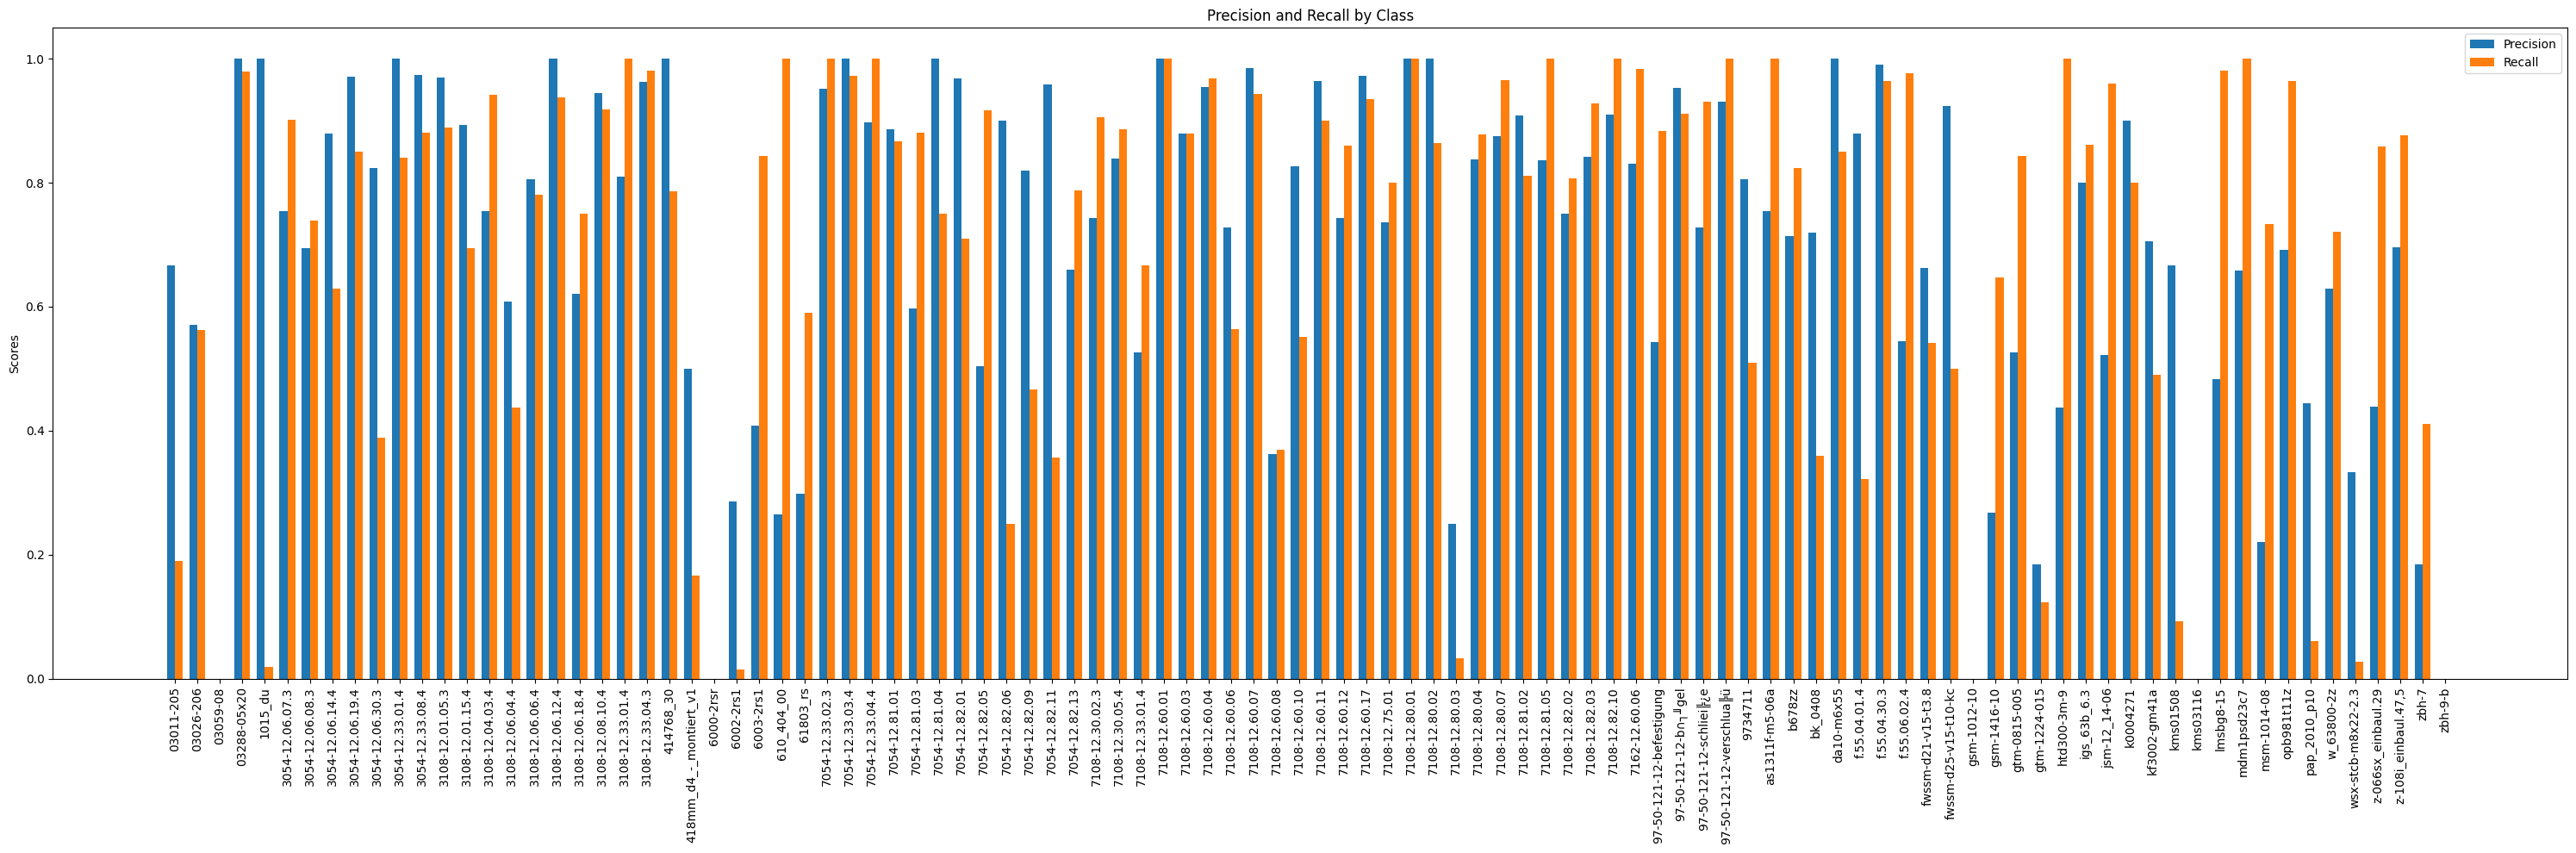

In [ ]:
precision = precision_score(all_labels.cpu(), predicted_labels.cpu(), average=None, labels=range(num_classes))
recall = recall_score(all_labels.cpu(), predicted_labels.cpu(), average=None, labels=range(num_classes))

x = np.arange(len(class_names))
width = 0.35
plt.figure(figsize=(30, 10))
ax = plt.subplot(111)
rects1 = ax.bar(x - width/2, precision, width, label='Precision')
rects2 = ax.bar(x + width/2, recall, width, label='Recall')

ax.set_ylabel('Scores')
ax.set_title('Precision and Recall by Class')
ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=90)
ax.legend()
plt.tight_layout()
plt.savefig('precision_recall_per_class_bar_chart.jpg', dpi=150)
plt.show()

In [ ]:
files.download("precision_recall_per_class_bar_chart.jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
class_name_of_interest = 'htd300-3m-9'

class_index = class_names.index(class_name_of_interest)
class_precision = precision[class_index]
class_recall = recall[class_index]

print(f"{class_name_of_interest} Precision Score: {class_precision}")
print(f"{class_name_of_interest} Recall Score: {class_recall}")

htd300-3m-9 Precision Score: 1.0
htd300-3m-9 Recall Score: 1.0


__Get Filenames of Correct Predictions by Class__


In [11]:
specific_class_name = "7108-12.60.17"
correct_images_for_class = correct_filenames_by_class_name.get(specific_class_name, [])
print(f"Number of Correct Predictions for Class '{specific_class_name}': {len(correct_images_for_class)}\n")
for filename in sorted(correct_images_for_class):
    print(filename + "\n")

Number of Correct Predictions for Class '7108-12.60.17': 62

/content/data_rgb/test/7108-12.60.17/test_7108-12.60.17_0000.png

/content/data_rgb/test/7108-12.60.17/test_7108-12.60.17_0001.png

/content/data_rgb/test/7108-12.60.17/test_7108-12.60.17_0002.png

/content/data_rgb/test/7108-12.60.17/test_7108-12.60.17_0003.png

/content/data_rgb/test/7108-12.60.17/test_7108-12.60.17_0004.png

/content/data_rgb/test/7108-12.60.17/test_7108-12.60.17_0005.png

/content/data_rgb/test/7108-12.60.17/test_7108-12.60.17_0006.png

/content/data_rgb/test/7108-12.60.17/test_7108-12.60.17_0007.png

/content/data_rgb/test/7108-12.60.17/test_7108-12.60.17_0008.png

/content/data_rgb/test/7108-12.60.17/test_7108-12.60.17_0009.png

/content/data_rgb/test/7108-12.60.17/test_7108-12.60.17_0010.png

/content/data_rgb/test/7108-12.60.17/test_7108-12.60.17_0011.png

/content/data_rgb/test/7108-12.60.17/test_7108-12.60.17_0012.png

/content/data_rgb/test/7108-12.60.17/test_7108-12.60.17_0013.png

/content/data_r

__Categorization by Manually Assigned Types__

In [20]:
file_path_in_drive = "/content/gdrive/MyDrive/Masterarbeit/code/data_analysis/categorizations.csv"
local_file_path = "/content/categorizations.csv"
shutil.copy(file_path_in_drive, local_file_path)
df = pd.read_csv(local_file_path, sep=',', encoding='ISO-8859-1').drop('index', axis=1)

print("Number of NaN:")
print(df.isna().sum())
print("Error: If there is more than 1 nan, do not run finllna()!")

df['Class Name'] = df['Class Name'].fillna('z-108i_einbaul.47,5')
df['Type Name'] = df['Type Name'].fillna('Springs')

df.loc[df['Class Name'].str.startswith('97-50-121-12-b') & ~df['Class Name'].str.startswith('97-50-121-12-befestigung'), 'Class Name'] = "97-50-121-12-b∩┐╜gel"
df.loc[df['Class Name'].str.startswith('97-50-121-12-verschlu'), 'Class Name'] = "97-50-121-12-verschlua╠ü"
df.loc[df['Class Name'].str.startswith('97-50-121-12-schlie'), 'Class Name'] = "97-50-121-12-schliei╠¿e"

type_mapping = {
    "Screw": "T1",
    "Ball Bearing": "T2",
    "Washer": "T3",
    "Sleeve Bearing": "T4",
    "Nut Insert": "T5",
    "Pen Shaped Object": "T6",
    "Plate": "T7",
    "Springs": "T8",
    "Rubber Band": "T9",
    "Mechanical Bracket": "T10",
    "Misc": "T11"
}

df['Type No.'] = df['Type Name'].map(type_mapping)

df

Number of NaN:
Class Name    1
Type Name     1
dtype: int64
Error: If there is more than 1 nan, do not run finllna()!


Class Name       Type Name Type No.
0              03011-205           Screw       T1
1              03026-206           Screw       T1
2               03059-08           Screw       T1
3            03288-05x20           Plate       T7
4                1015_du  Sleeve Bearing       T4
..                   ...             ...      ...
97    wsx-stcb-m8x22-2.3          Washer       T3
98    z-066sx_einbaul.29         Springs       T8
99   z-108i_einbaul.47,5         Springs       T8
100                zbh-7  Sleeve Bearing       T4
101              zbh-9-b  Sleeve Bearing       T4

[102 rows x 3 columns]

In [21]:
class_idx_2_class_name = {i: test_dataset.get_class_name(i) for i in range(102)}
precision = precision_score(all_labels.cpu(), predicted_labels.cpu(), average=None, labels=range(num_classes))
recall = recall_score(all_labels.cpu(), predicted_labels.cpu(), average=None, labels=range(num_classes))

class_metrics_df = pd.DataFrame({
    'Class Index': class_idx_2_class_name.keys(),
    'Class Name': class_idx_2_class_name.values(),
    'Precision': precision,
    'Recall': recall
})

class_metrics_df.loc[class_metrics_df['Class Index'] == 67, 'Class Name'] = "97-50-121-12-b∩┐╜gel"
class_metrics_df.loc[class_metrics_df['Class Index'] == 68, 'Class Name'] = "97-50-121-12-schliei╠¿e"
class_metrics_df.loc[class_metrics_df['Class Index'] == 69, 'Class Name'] = "97-50-121-12-verschlua╠ü"

merged_df = pd.merge(df, class_metrics_df, on='Class Name', how='left')
merged_df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Class Name       Type Name Type No.  Class Index  Precision  \
0              03011-205           Screw       T1            0   0.740741   
1              03026-206           Screw       T1            1   0.595238   
2               03059-08           Screw       T1            2   0.100000   
3            03288-05x20           Plate       T7            3   1.000000   
4                1015_du  Sleeve Bearing       T4            4   0.000000   
..                   ...             ...      ...          ...        ...   
97    wsx-stcb-m8x22-2.3          Washer       T3           97   0.000000   
98    z-066sx_einbaul.29         Springs       T8           98   0.459302   
99   z-108i_einbaul.47,5         Springs       T8           99   0.719626   
100                zbh-7  Sleeve Bearing       T4          100   0.174419   
101              zbh-9-b  Sleeve Bearing       T4          101   0.444444   

       Recall  
0    0.190476  
1    0.619835  
2    0.033898  
3    0.958333  
4    0.000000  
..        ...  
97   0.000000  
98   0.858696  
99   0.865169  
100  0.384615  
101  0.037037  

[102 rows x 6 columns]

In [22]:
type_counts = merged_df['Type No.'].value_counts()
type_counts

T7     24
T10    17
T4     16
T11    10
T5      8
T2      8
T1      7
T6      4
T9      3
T3      3
T8      2
Name: Type No., dtype: int64

_Calculated per Class Average Recall and Precision aggregated for Type_

In [23]:
type_name_averages = merged_df.groupby('Type No.')['Precision', 'Recall'].mean().reset_index()
type_name_averages

<ipython-input-23-6ccc508bbe71>:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



Type No.  Precision    Recall
0        T1   0.696342  0.610114
1       T10   0.792003  0.855223
2       T11   0.840709  0.859086
3        T2   0.296090  0.506488
4        T3   0.244963  0.326614
5        T4   0.509268  0.428447
6        T5   0.780541  0.703311
7        T6   0.737619  0.739583
8        T7   0.888294  0.856199
9        T8   0.589464  0.861932
10       T9   0.789427  0.575964

_Out-of-Type Misclassification Rate_

In [24]:
predicted_class_names = [class_names[label] for label in predicted_labels.cpu().numpy()]
#class_to_type_name = merged_df.set_index('Class Name')['Type Name'].to_dict()
class_to_type_name = merged_df.set_index('Class Name')['Type No.'].to_dict()
predicted_type_names = [class_to_type_name[class_name] for class_name in predicted_class_names]
true_labels_class_names = [class_names[label] for label in all_labels.cpu().numpy()]
true_type_names = [class_to_type_name[class_name] for class_name in true_labels_class_names]
misclassified = [pred_type != true_type for pred_type, true_type in zip(predicted_type_names, true_type_names)]
misclassified_counts = sum(misclassified)

analysis_df = pd.DataFrame({
    'True Type': true_type_names,
    'Predicted Type': predicted_type_names,
    'Misclassified': misclassified
})

misclassification_by_type = analysis_df[analysis_df['Misclassified']].groupby('True Type').size()

total_instances_per_type = analysis_df.groupby('True Type').size()
misclassification_rate_per_type = misclassification_by_type / total_instances_per_type
misclassification_percentage_per_type = round(misclassification_rate_per_type * 100, 2)
misclassification_percentage_per_type

True Type
T1     20.14
T10     7.20
T11     8.63
T2      1.10
T3     12.78
T4     15.51
T5     24.45
T6      3.03
T7      6.86
T8      1.10
T9     26.27
dtype: float64

In [25]:
flow_df = analysis_df.groupby(['True Type', 'Predicted Type']).size().reset_index(name='Count')
flow_df

True Type Predicted Type  Count
0         T1             T1    448
1         T1            T10      1
2         T1            T11      1
3         T1             T2      2
4         T1             T5      4
..       ...            ...    ...
61        T9            T11      3
62        T9             T4      7
63        T9             T5      1
64        T9             T7     17
65        T9             T9     87

[66 rows x 3 columns]

_Flow Chart of Type Predictions_

In [26]:
unique_types = pd.concat([flow_df['True Type'], flow_df['Predicted Type']]).unique()
type_mapping = {t: i for i, t in enumerate(unique_types)}

source = [type_mapping[true_type] for true_type in flow_df['True Type']]
target = [type_mapping[pred_type] + len(unique_types) for pred_type in flow_df['Predicted Type']]
value = flow_df['Count'].tolist()

labels = list(unique_types) + list(unique_types)

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color='black', width=0.5),
        label=labels,
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    ))])

fig.update_layout(title_text="Flow of Misclassifications by Type", font_size=10)
fig.show()


_Confusion Matrix for Type Predictions_

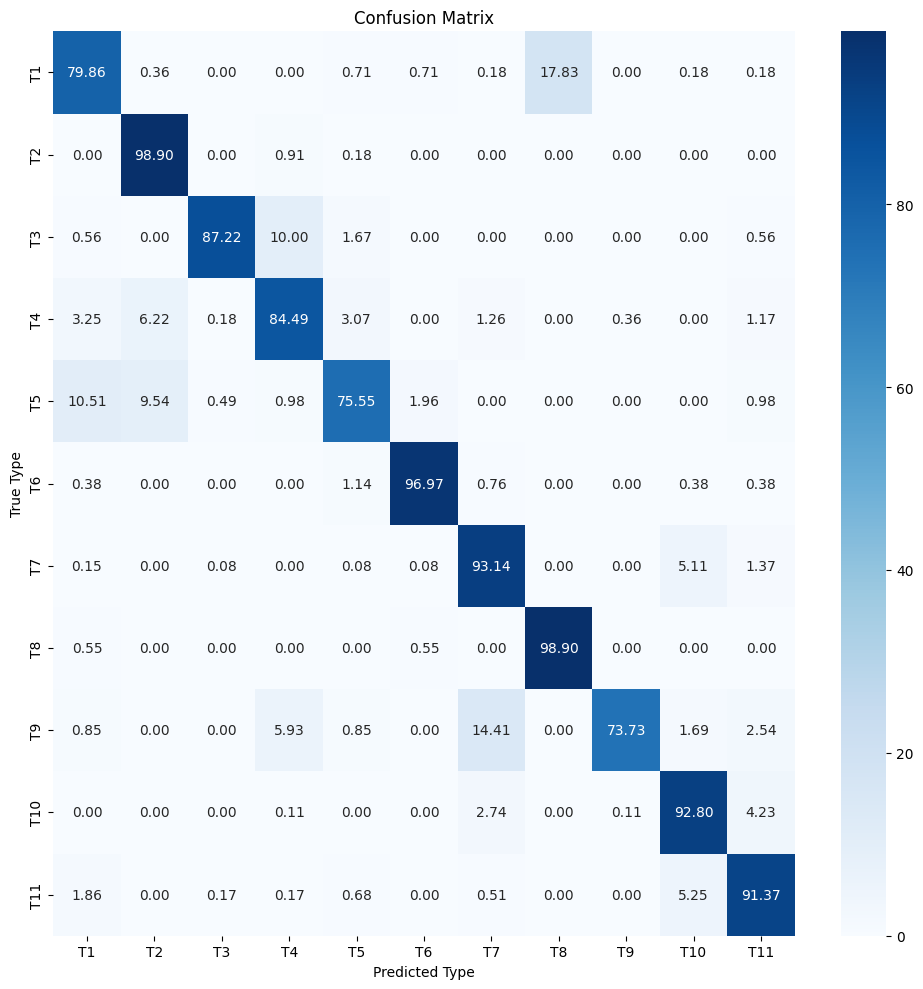

In [27]:
cm_flow_df = flow_df.pivot_table(index='True Type', columns='Predicted Type', values='Count', aggfunc='sum', fill_value=0)
row_sums = cm_flow_df.sum(axis=1)
cm_flow_df_normalized = cm_flow_df.div(row_sums, axis=0)
cm_flow_df_normalized = cm_flow_df_normalized * 100

sorted_labels = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11']
cm_flow_df_normalized = cm_flow_df_normalized.reindex(index=sorted_labels, columns=sorted_labels, fill_value=0)

plt.figure(figsize=(10, 10))
sns.heatmap(cm_flow_df_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('True Type')
plt.xlabel('Predicted Type')
plt.tight_layout()
plt.savefig('confusion_matrix_types.jpg', dpi=150)
plt.show()

__Set Up Comparisons__

In [ ]:
#Normalized Depth CustomTransforms
test_dataset_comparative = CustomImageDataset(rgb_folder_path='/content/data_rgb/test', depth_folder_path='/content/data_depth/test', processor=None, transform=CustomTransforms().synchronized_transform_val)

#Normalized Depth AutoImageProcessor
#processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-base-patch4-window12-192-22k")
#test_dataset_comparative = CustomImageDataset(rgb_folder_path='/content/data_rgb/test', depth_folder_path='/content/data_depth/test', processor=processor, transform=None)

#Metric Depth
#test_dataset_comparative = CustomImageDataset(rgb_folder_path='/content/data_rgb/test', depth_folder_path='/content/data_depth_metric/test', processor=None, transform=CustomTransforms().synchronized_transform_val_metric)

test_loader_comparative = DataLoader(test_dataset_comparative, batch_size=32, shuffle=False)

#file_path_in_drive_comparative_model = "/content/gdrive/MyDrive/Masterarbeit/models/best_models/best_model_latefusion_ch_ft_metric_depth.pt"
#file_path_in_drive_comparative_model = "/content/gdrive/MyDrive/Masterarbeit/models/best_models/best_model_latefusion_ch_metric_depth.pt"
file_path_in_drive_comparative_model = "/content/gdrive/MyDrive/Masterarbeit/models/best_models/best_model_latefusion_ch_ft_normalized_depth.pt"
#file_path_in_drive_comparative_model = "/content/gdrive/MyDrive/Masterarbeit/models/best_models/best_model_latefusion_ch_autoimageprocessor_normalized_depth.pt"
#file_path_in_drive_comparative_model = "/content/gdrive/MyDrive/Masterarbeit/models/best_models/best_model_latefusion_ch_customtransforms_normalized_depth.pt"
#file_path_in_drive_comparative_model = "/content/gdrive/MyDrive/Masterarbeit/models/best_models/best_model_earlyfusion_ch_ft_normalized_depth.pt"
#file_path_in_drive_comparative_model = "/content/gdrive/MyDrive/Masterarbeit/models/best_models/best_model_earlyfusion_ch_customtransforms_normalized_depth.pt"


local_file_path = '/content/comparative_model.pt'
shutil.copy(file_path_in_drive_comparative_model, local_file_path)

DEVICE = torch.device("cuda:0")

saved_comparative_model_path = "/content/comparative_model.pt"

base_model_swin_rgb = AutoModelForImageClassification.from_pretrained("microsoft/swinv2-base-patch4-window12-192-22k", num_labels=102, ignore_mismatched_sizes=True)
base_model_swin_depth = AutoModelForImageClassification.from_pretrained("microsoft/swinv2-base-patch4-window12-192-22k", num_labels=102, ignore_mismatched_sizes=True)
classifier_model_swin_rgbd = AutoModelForImageClassification.from_pretrained("microsoft/swinv2-base-patch4-window12-192-22k", num_labels=102, ignore_mismatched_sizes=True)

ensemble_comparative_model = EnsembleModel(base_model_swin_rgb, base_model_swin_depth, classifier_model_swin_rgbd)

comparative_model_save_dict = torch.load(saved_comparative_model_path)

ensemble_comparative_model.model_rgb.load_state_dict(comparative_model_save_dict['model_rgb_state_dict'])
ensemble_comparative_model.model_depth.load_state_dict(comparative_model_save_dict['model_depth_state_dict'])
ensemble_comparative_model.model_rgbd_classifier.load_state_dict(comparative_model_save_dict['model_rgbd_classifier_state_dict'])

loaded_comparative_model = ensemble_comparative_model.to(DEVICE)

all_outputs_comparative_model, all_labels_comparative_model, accuracy_comparative_model, balanced_acc_comparative_model, f1_macro_comparative_model, correct_filenames_by_class_name_comparative_model = test_model(loaded_comparative_model, test_loader_comparative, test_dataset_comparative)

print(f"Comparative Model Results: ")
print(f"Test Accuracy: {accuracy_comparative_model:.2f}%")
print(f"Test Balanced Accuracy: {balanced_acc_comparative_model:.2f}%")
print(f"Test F1-Macro: {f1_macro_comparative_model:.2f}%")

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window12-192-22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1024]) in the checkpoint and torch.Size([102, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([102]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-base-patch4-window12-192-22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1024]) in the checkpoint and torch.Size([102, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([102]) in the model inst

Comparative Model Results: 
Test Accuracy: 64.71%
Test Balanced Accuracy: 65.47%
Test F1-Macro: 62.60%


__Comparison Confusion Matrix__

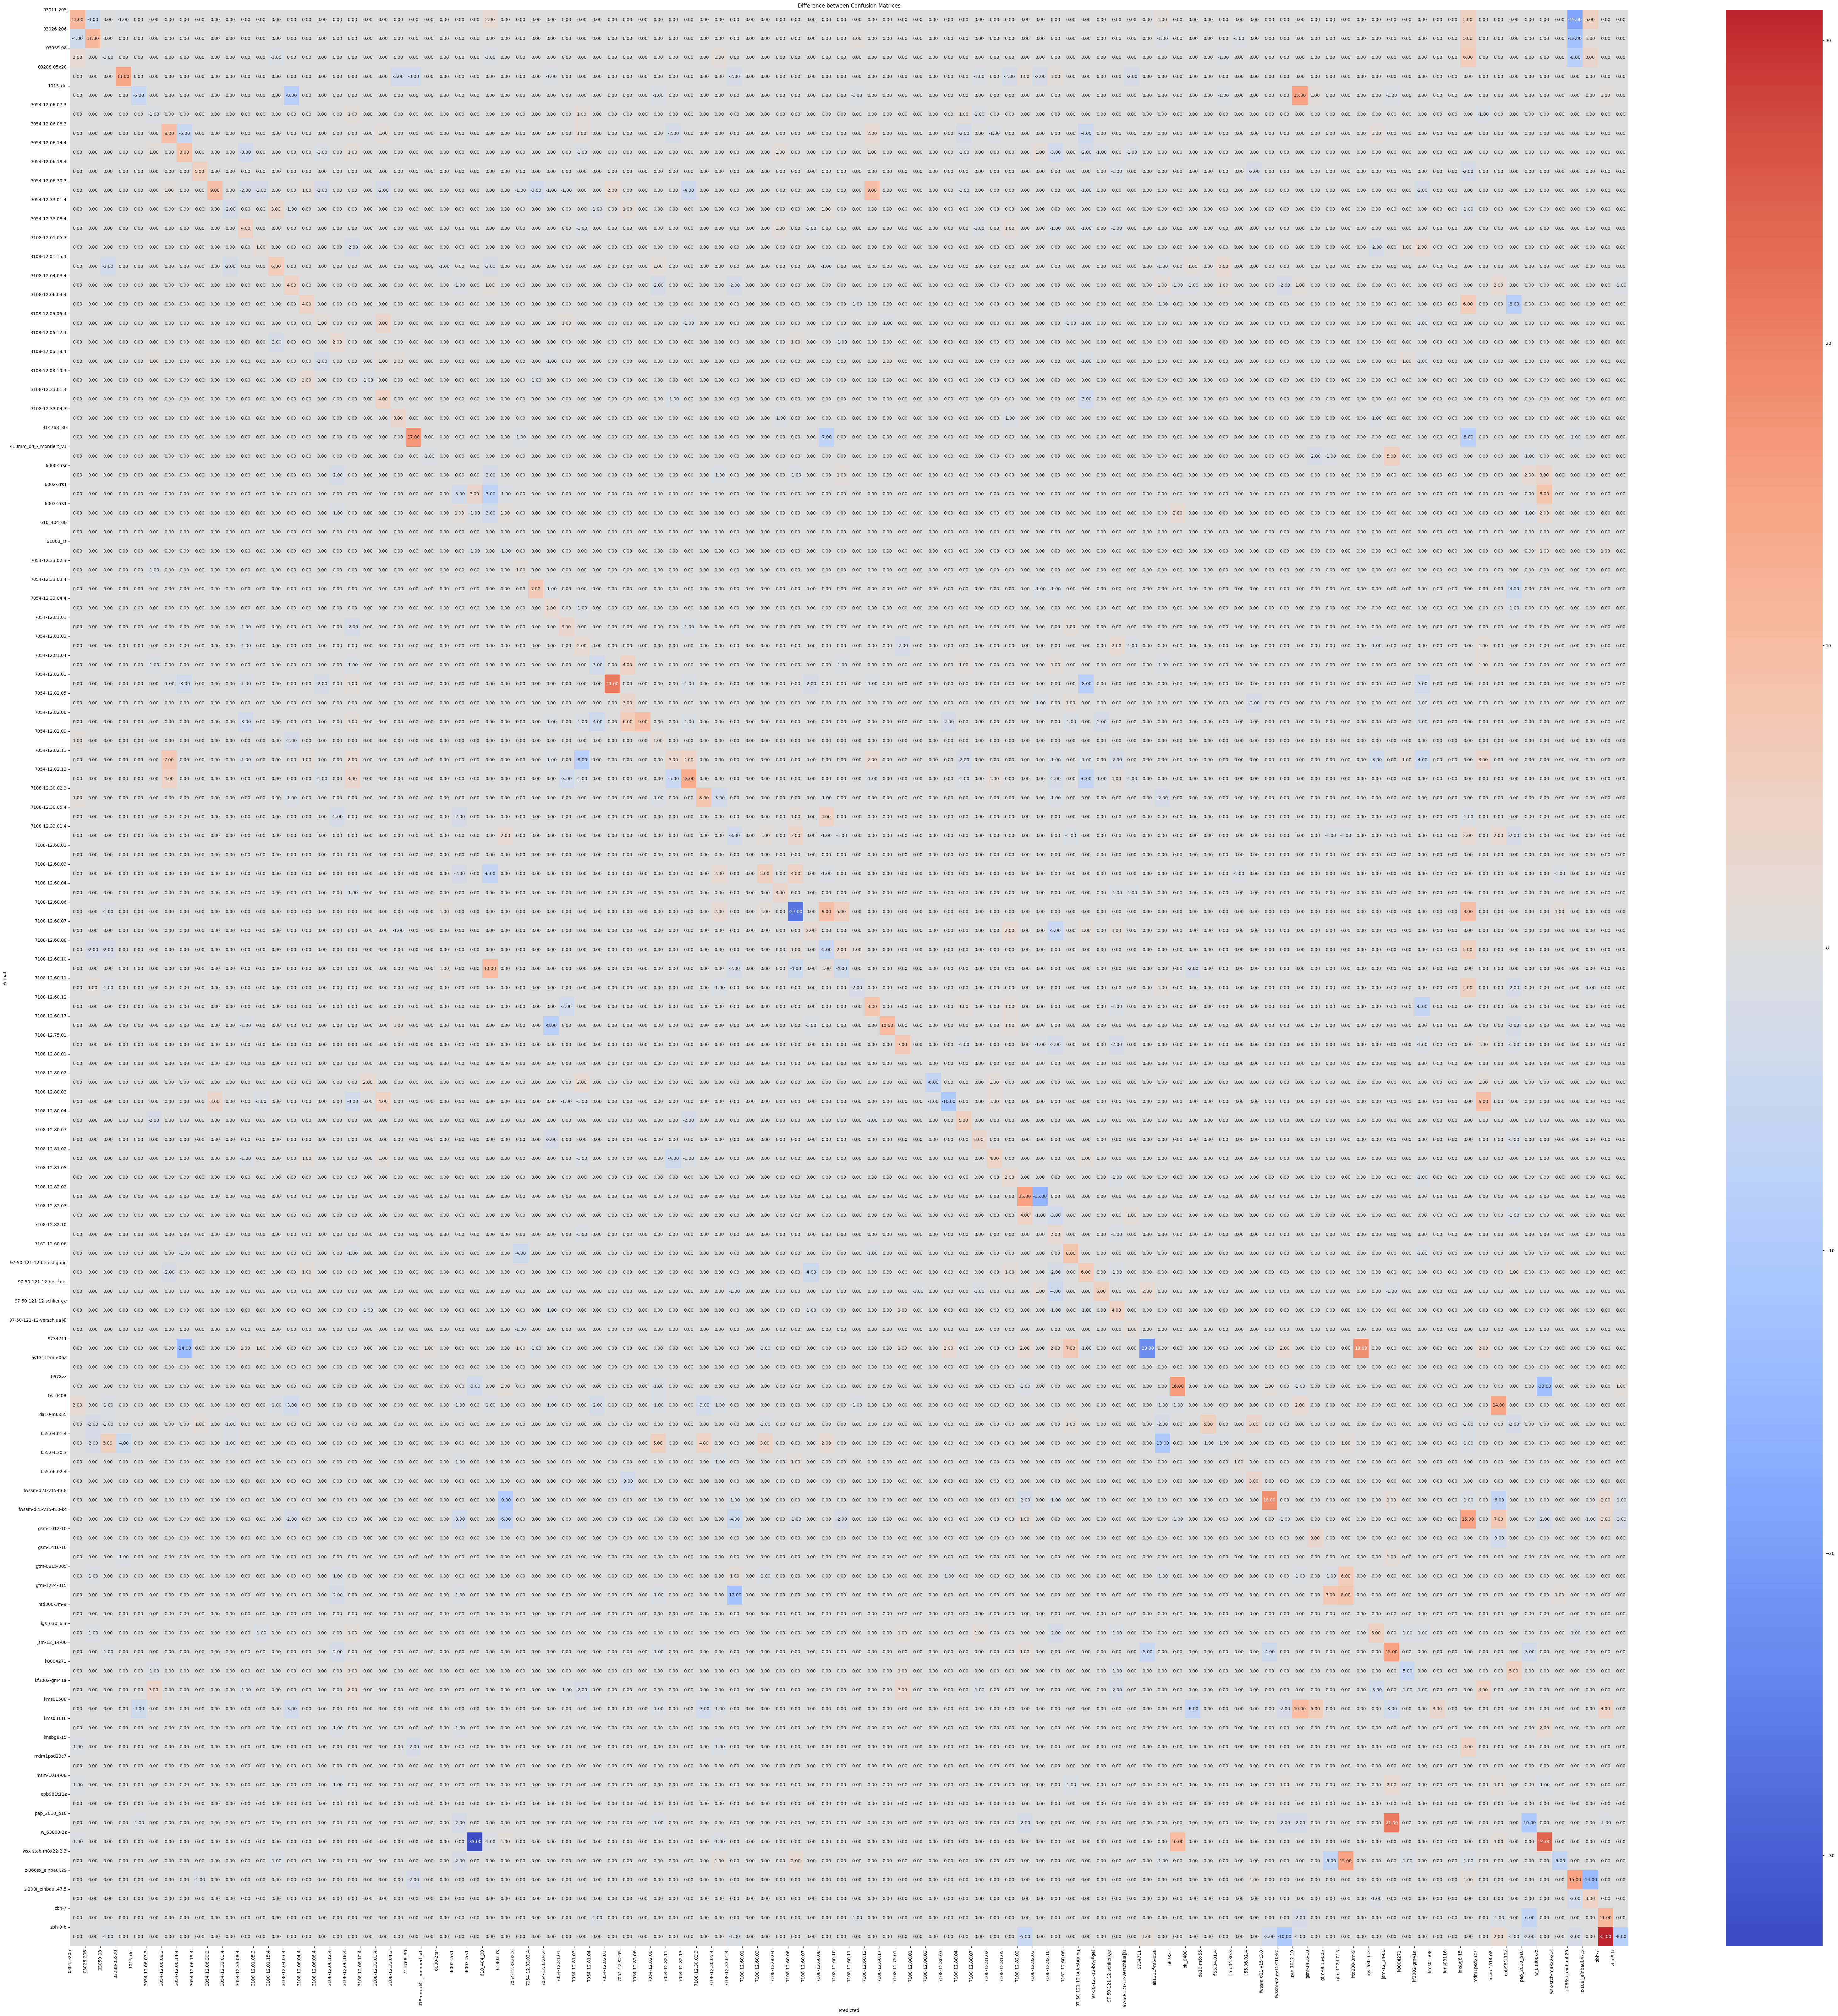

In [ ]:
num_classes = len(np.unique(all_labels.cpu().numpy()))
class_names = [test_dataset.get_class_name(i) for i in range(num_classes)]

predicted_labels_base_model = torch.max(all_outputs, 1)[1]
predicted_labels_comparative_model = torch.max(all_outputs_comparative_model, 1)[1]

cm_base_model = confusion_matrix(all_labels.cpu().numpy(), predicted_labels_base_model.cpu().numpy())
cm_comparative_model = confusion_matrix(all_labels_comparative_model.cpu().numpy(), predicted_labels_comparative_model.cpu().numpy())
title = 'confusion_matrix_difference'

#title = 'normalized_confusion_matrix_difference'
#cm_base_model = cm_base_model.astype('float') / cm_base_model.sum(axis=1)[:, np.newaxis]
#cm_comparative_model = cm_comparative_model.astype('float') / cm_comparative_model.sum(axis=1)[:, np.newaxis]

cm_diff = cm_base_model - cm_comparative_model

plt.figure(figsize=(80, 80))
sns.heatmap(cm_diff, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Difference between Confusion Matrices')
plt.xticks(np.arange(num_classes), class_names, rotation=90)
plt.yticks(np.arange(num_classes), class_names, rotation=0)
plt.savefig(title + ".jpg", dpi=150)
plt.show()

In [ ]:
files.download(title + ".jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

__Comparison Confusion Matrices Cumulative Difference__

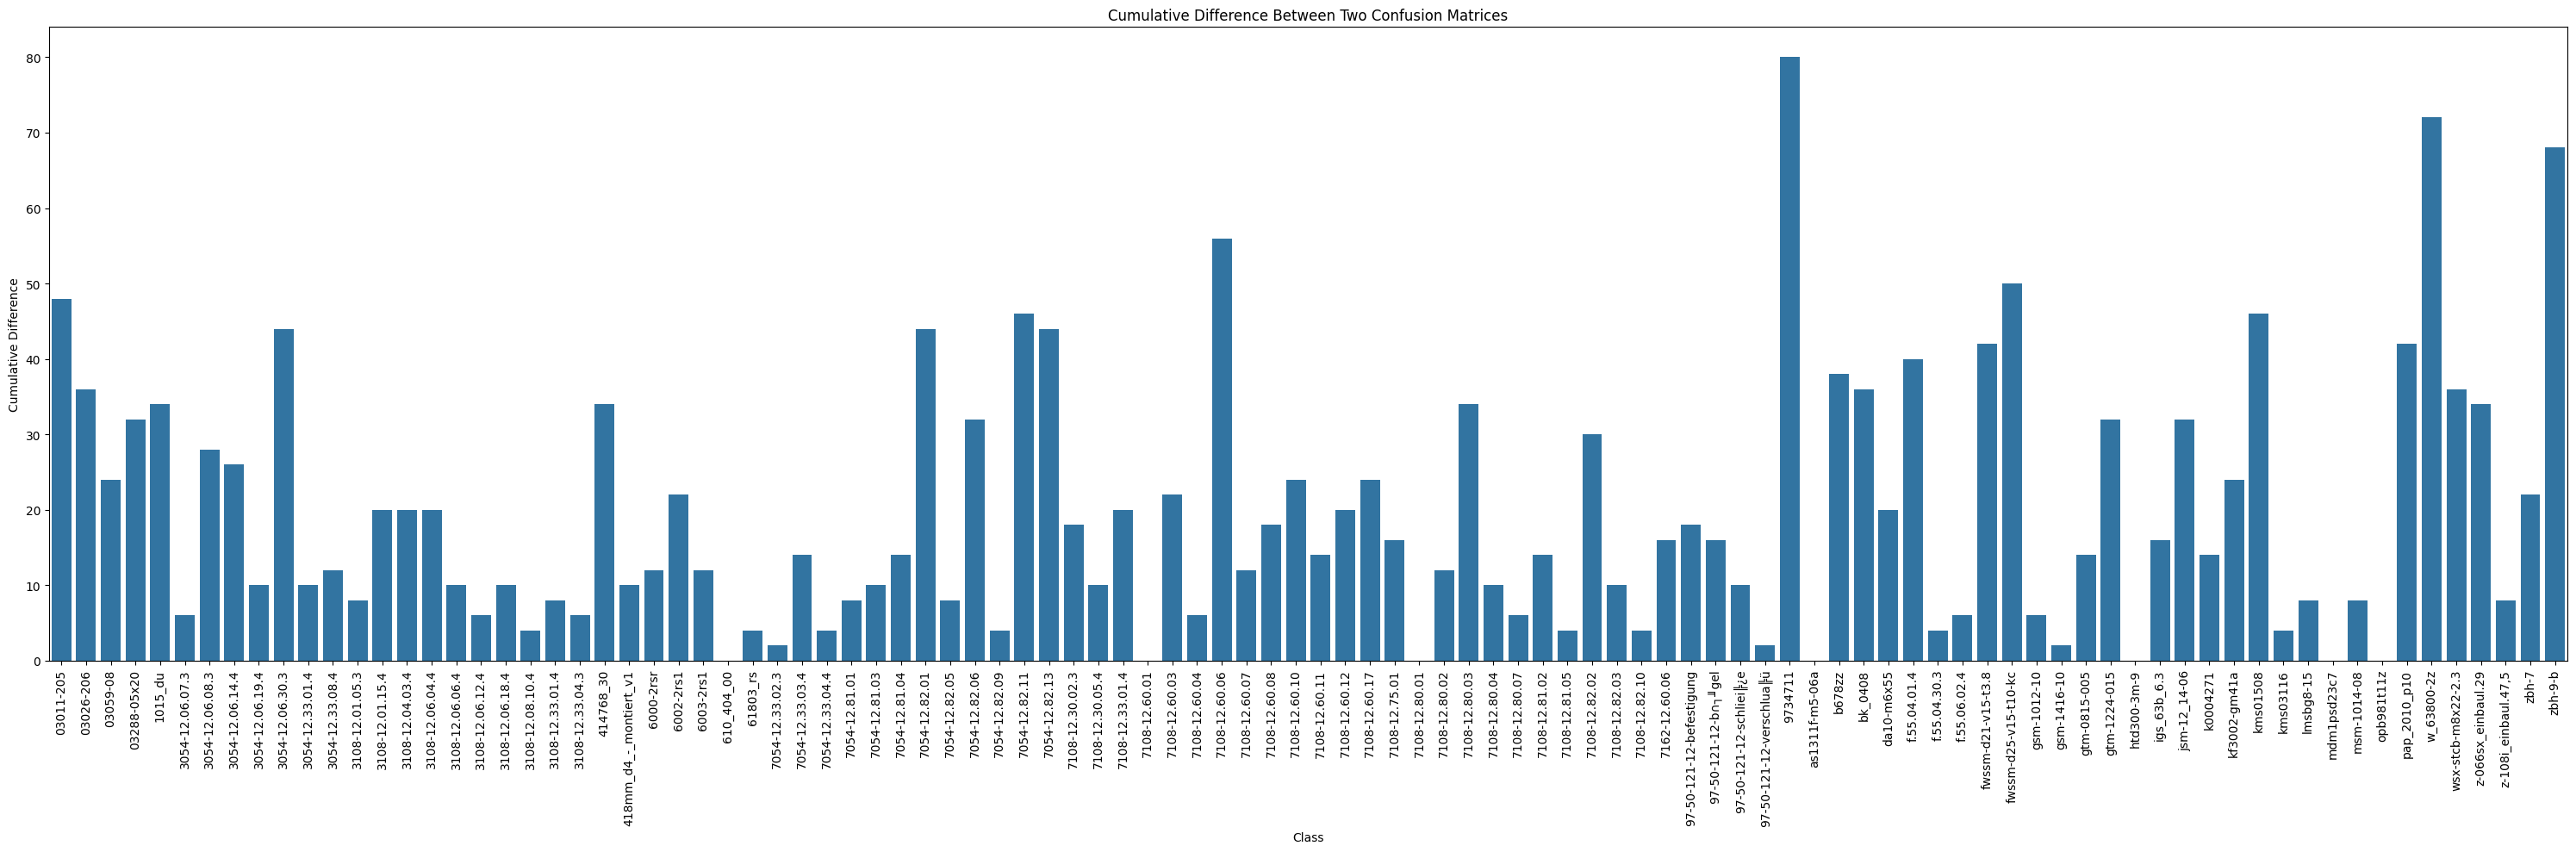

In [ ]:
diff = np.abs(cm_base_model - cm_comparative_model)
cumulative_diff = np.sum(diff, axis=1)

plt.figure(figsize=(30, 10))
sns.barplot(x=class_names, y=cumulative_diff)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Cumulative Difference')
plt.title('Cumulative Difference Between Two Confusion Matrices')
plt.tight_layout()
plt.savefig('barchart_cumulative_difference_confusion_matrices.jpg', dpi=150)
plt.show()

In [ ]:
files.download("barchart_cumulative_difference_confusion_matrices.jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

__Comparison Precision__

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


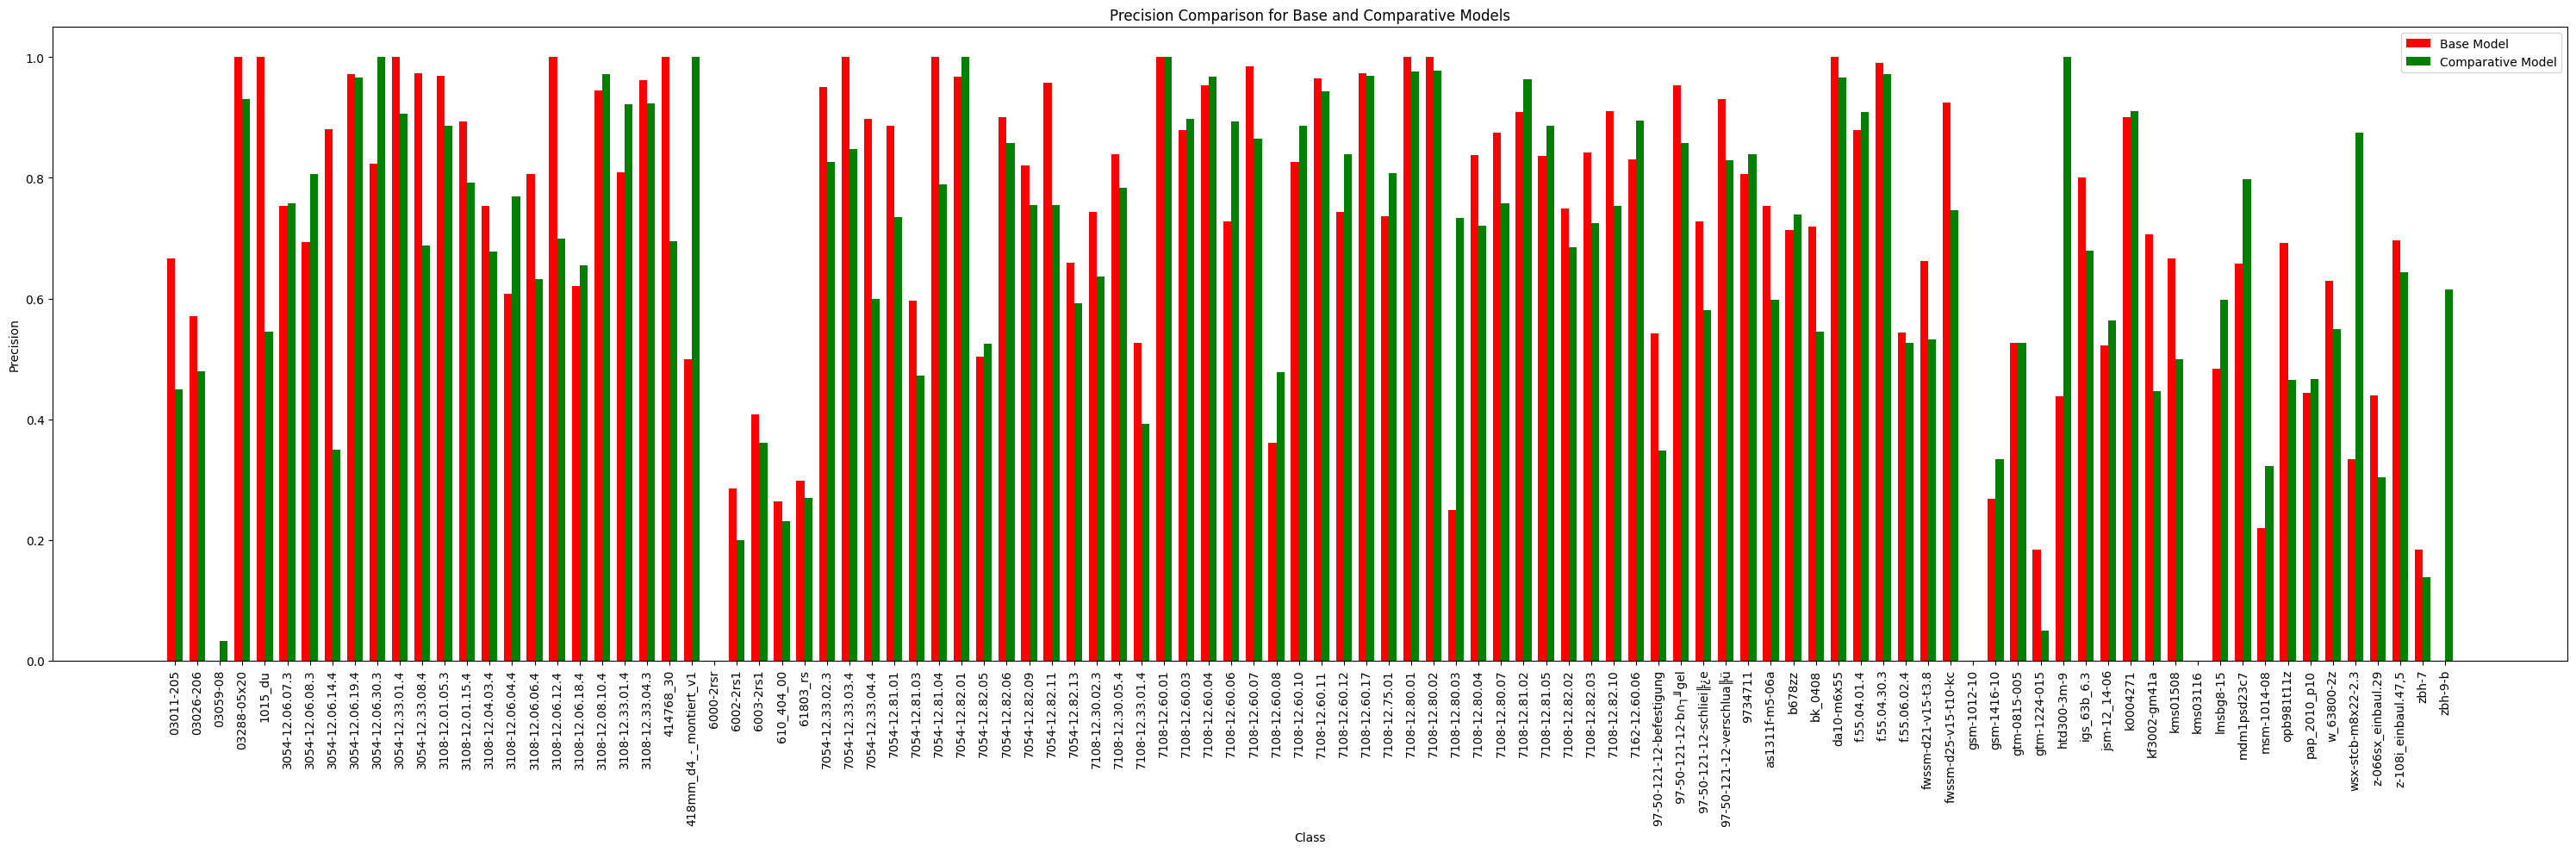

In [ ]:
precision_base_model = precision_score(all_labels.cpu(), predicted_labels.cpu(), average=None, labels=range(num_classes))
precision_comparative_model = precision_score(all_labels_comparative_model.cpu(), predicted_labels_comparative_model.cpu(), average=None, labels=range(num_classes))

x = np.arange(num_classes)
width = 0.35

plt.figure(figsize=(30, 10))
rects1 = plt.bar(x - width/2, precision_base_model, width, color='red', label='Base Model')
rects2 = plt.bar(x + width/2, precision_comparative_model, width, color='green', label='Comparative Model')

plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision Comparison for Base and Comparative Models')
plt.xticks(x, class_names, rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig('precision_per_class_comparison.jpg', dpi=150)
plt.show()

In [ ]:
files.download("precision_per_class_comparison.jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
class_name_of_interest = 'zbh-9-b'

class_index = class_names.index(class_name_of_interest)
class_precision_base_model = precision_base_model[class_index]
class_precision_comparative_model = precision_comparative_model[class_index]

print(f"{class_name_of_interest} Precision Base Model: {class_precision_base_model}")
print(f"{class_name_of_interest} Precision Comparative Model: {class_precision_comparative_model}")

zbh-9-b Precision Base Model: 0.0
zbh-9-b Precision Comparative Model: 0.6153846153846154


__Comparison Recall__

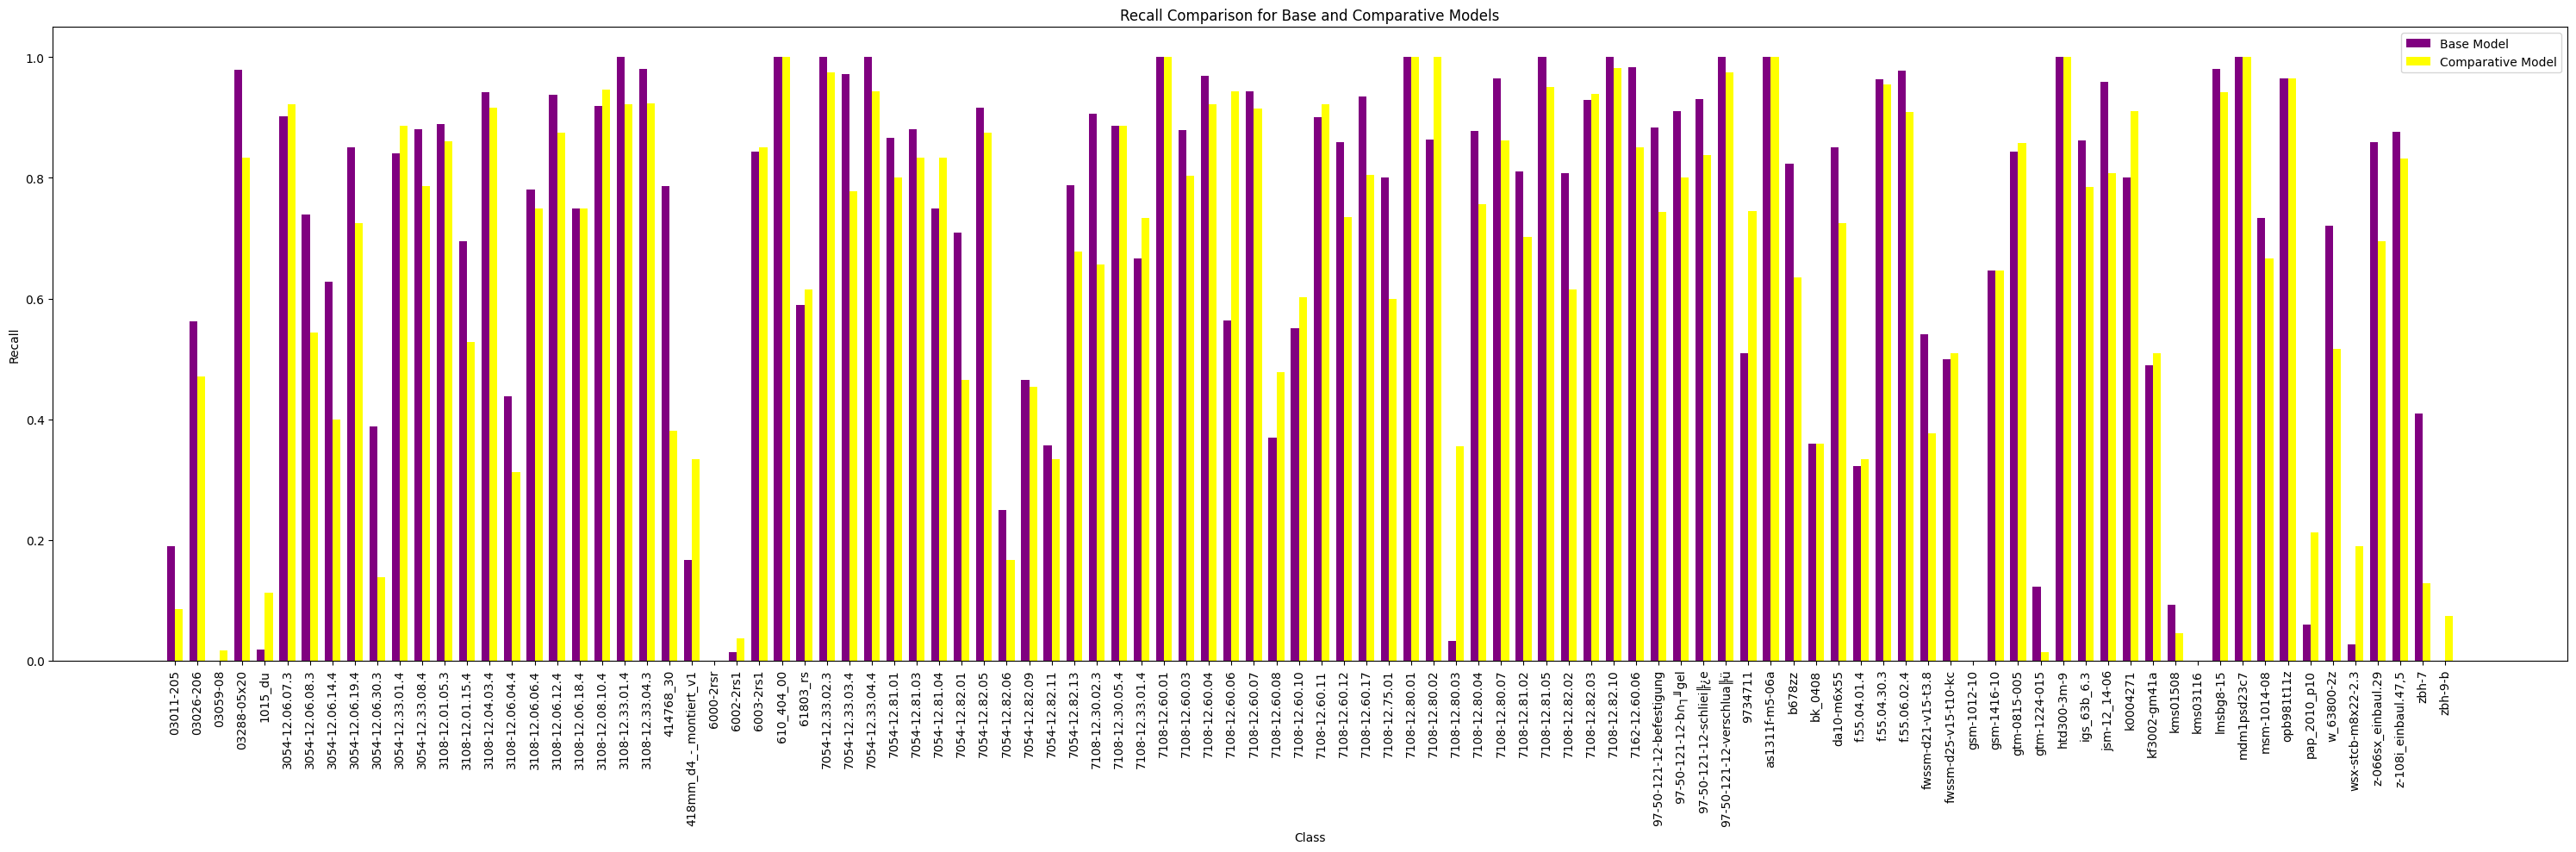

In [ ]:
recall_base_model = recall_score(all_labels.cpu(), predicted_labels.cpu(), average=None, labels=range(num_classes))
recall_comparative_model = recall_score(all_labels_comparative_model.cpu(), predicted_labels_comparative_model.cpu(), average=None, labels=range(num_classes))

plt.figure(figsize=(30, 10))
rects1 = plt.bar(x - width/2, recall_base_model, width, color='purple', label='Base Model')
rects2 = plt.bar(x + width/2, recall_comparative_model, width, color='yellow', label='Comparative Model')

plt.xlabel('Class')
plt.ylabel('Recall')
plt.title('Recall Comparison for Base and Comparative Models')
plt.xticks(x, class_names, rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig('recall_per_class_comparison.jpg', dpi=150)
plt.show()


In [ ]:
files.download("recall_per_class_comparison.jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
class_name_of_interest = 'wsx-stcb-m8x22-2.3'

class_index = class_names.index(class_name_of_interest)
class_recall_base_model = recall_base_model[class_index]
class_recall_comparative_model = recall_comparative_model[class_index]

print(f"{class_name_of_interest} Recall Base Model: {class_recall_base_model}")
print(f"{class_name_of_interest} Recall Comparative Model: {class_recall_comparative_model}")

wsx-stcb-m8x22-2.3 Recall Base Model: 0.02702702702702703
wsx-stcb-m8x22-2.3 Recall Comparative Model: 0.1891891891891892


__Comparison Differences in Precision and Recall__


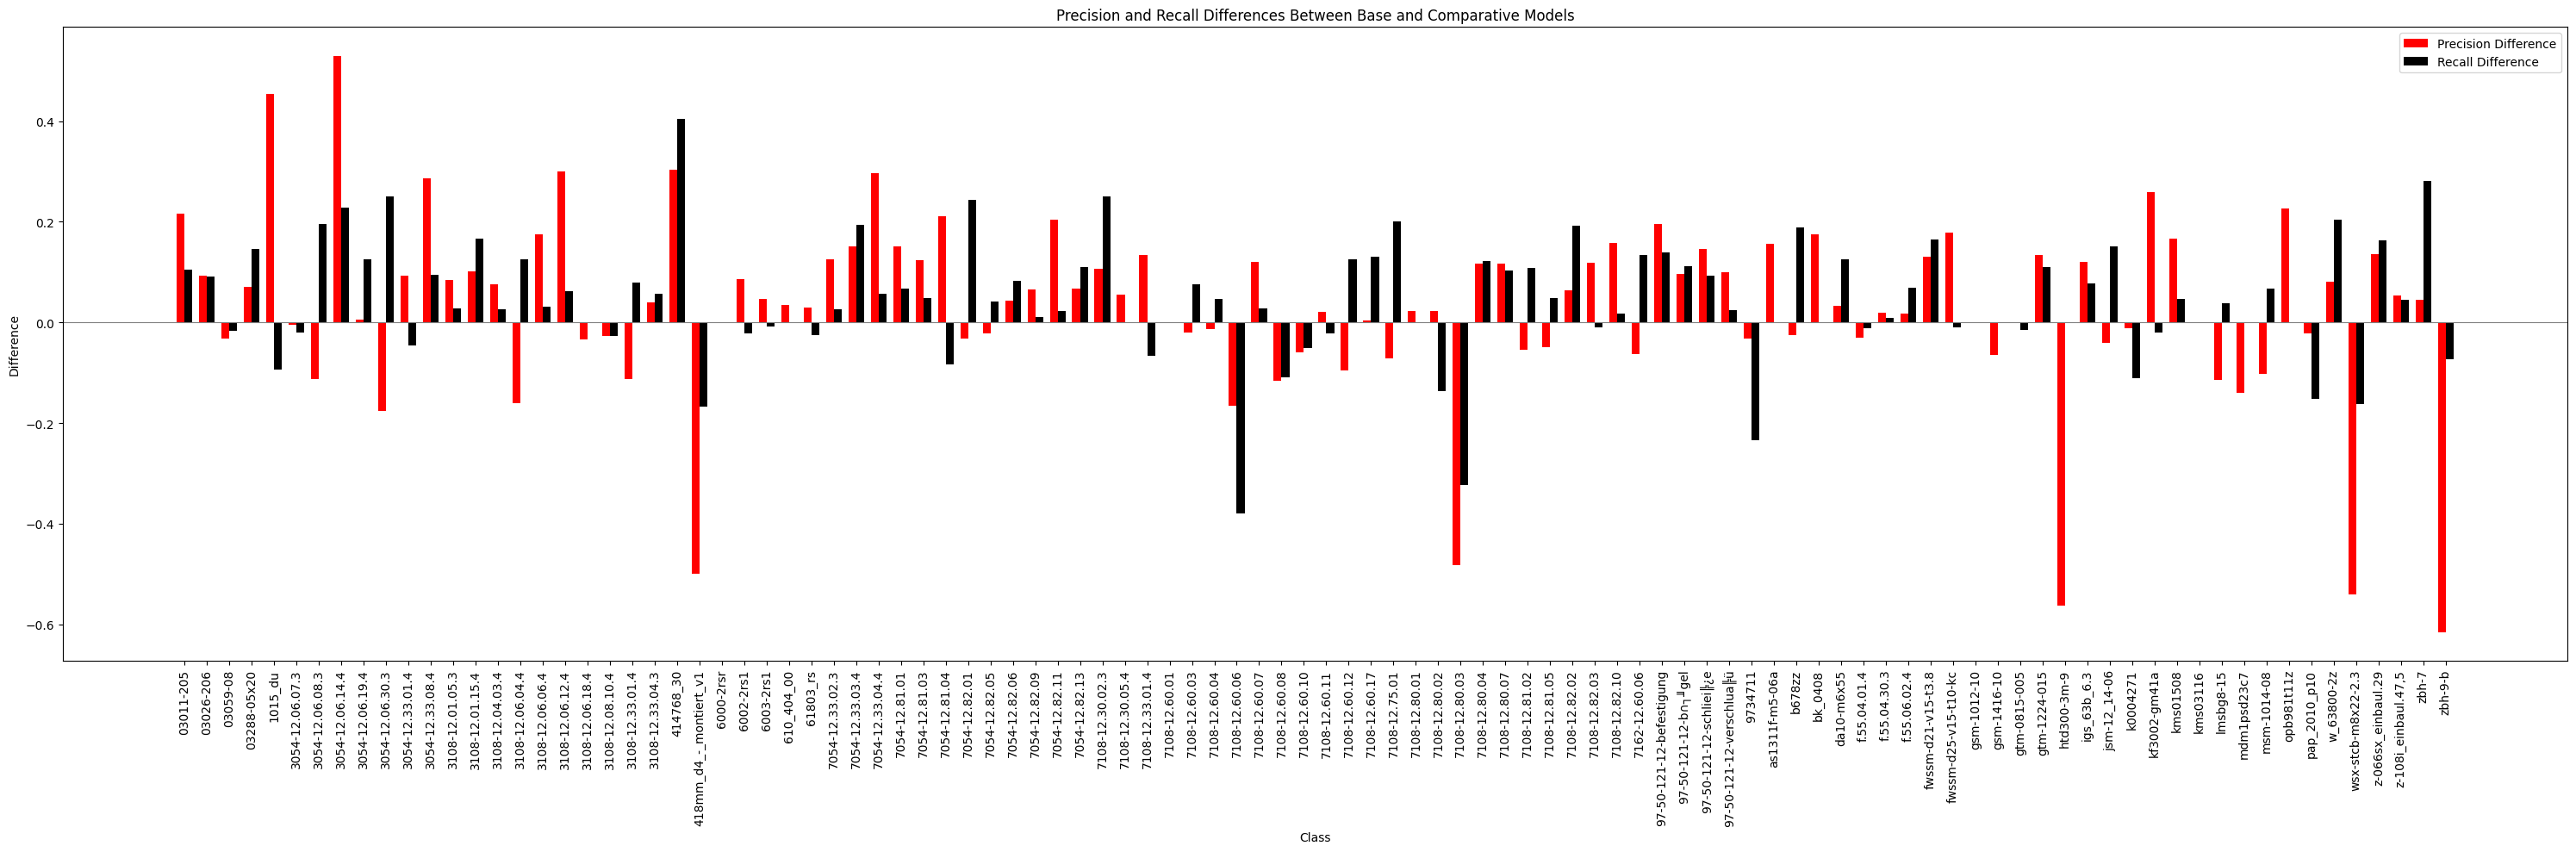

In [ ]:
precision_difference = precision_base_model - precision_comparative_model
recall_difference = recall_base_model - recall_comparative_model

x = np.arange(num_classes)
width = 0.35
plt.figure(figsize=(30, 10))
plt.bar(x - width/2, precision_difference, width, label='Precision Difference', color='red')
plt.bar(x + width/2, recall_difference, width, label='Recall Difference', color='black')
plt.xlabel('Class')
plt.ylabel('Difference')
plt.title('Precision and Recall Differences Between Base and Comparative Models')
plt.xticks(x, class_names, rotation=90)
plt.axhline(0, color='grey', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.savefig('recall_precision_difference_model_comparison.jpg', dpi=150)
plt.show()

In [ ]:
files.download("recall_precision_difference_model_comparison.jpg")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

__Total Number of Precision/Recall Improvements per Class per Model__

In [ ]:
num_classes_higher_precision_base = np.sum(precision_base_model > precision_comparative_model)
num_classes_higher_precision_comparative = np.sum(precision_comparative_model > precision_base_model)
num_classes_higher_recall_base = np.sum(recall_base_model > recall_comparative_model)
num_classes_higher_recall_comparative = np.sum(recall_comparative_model > recall_base_model)

print(f"Number of classes where the base model has higher precision: {num_classes_higher_precision_base}")
print(f"Number of classes where the comparative model has higher precision: {num_classes_higher_precision_comparative}")
print(f"Number of classes where the base model has higher recall: {num_classes_higher_recall_base}")
print(f"Number of classes where the comparative model has higher recall: {num_classes_higher_recall_comparative}")

Number of classes where the base model has higher precision: 63
Number of classes where the comparative model has higher precision: 35
Number of classes where the base model has higher recall: 61
Number of classes where the comparative model has higher recall: 27


__Comparison Get Filenames of Correct Predictions by Class__


In [ ]:
specific_class_name_comparative_model = "htd300-3m-9"
correct_images_for_class_comparative_model = correct_filenames_by_class_name_comparative_model.get(specific_class_name_comparative_model, [])
print(f"Number of Correct Predictions for Class '{specific_class_name_comparative_model}': {len(correct_images_for_class_comparative_model)}\n")
for filename in sorted(correct_images_for_class_comparative_model):
    print(filename + "\n")

Number of Correct Predictions for Class 'htd300-3m-9': 14

/content/data_rgb/test/htd300-3m-9/test_htd300-3m-9_0000.png

/content/data_rgb/test/htd300-3m-9/test_htd300-3m-9_0001.png

/content/data_rgb/test/htd300-3m-9/test_htd300-3m-9_0002.png

/content/data_rgb/test/htd300-3m-9/test_htd300-3m-9_0003.png

/content/data_rgb/test/htd300-3m-9/test_htd300-3m-9_0004.png

/content/data_rgb/test/htd300-3m-9/test_htd300-3m-9_0005.png

/content/data_rgb/test/htd300-3m-9/test_htd300-3m-9_0006.png

/content/data_rgb/test/htd300-3m-9/test_htd300-3m-9_0007.png

/content/data_rgb/test/htd300-3m-9/test_htd300-3m-9_0008.png

/content/data_rgb/test/htd300-3m-9/test_htd300-3m-9_0009.png

/content/data_rgb/test/htd300-3m-9/test_htd300-3m-9_0010.png

/content/data_rgb/test/htd300-3m-9/test_htd300-3m-9_0011.png

/content/data_rgb/test/htd300-3m-9/test_htd300-3m-9_0012.png

/content/data_rgb/test/htd300-3m-9/test_htd300-3m-9_0013.png



__Training Progress Visualization Single Model__

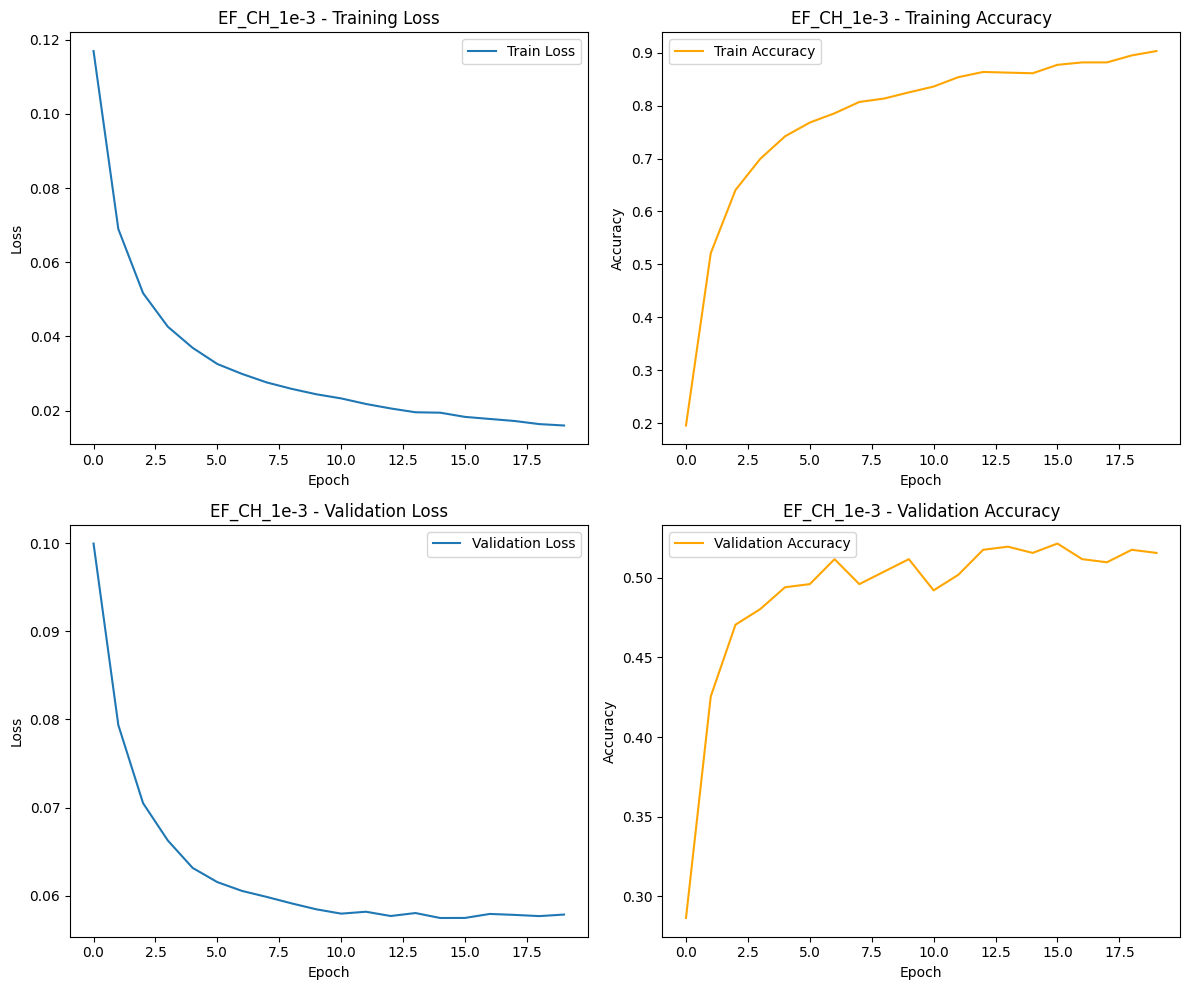

In [ ]:
def plot_training_progress(data, training_run_title):
    plt.figure(figsize=(12, 10))

    # Training Loss
    plt.subplot(2, 2, 1)
    plt.plot(data['train_loss'], label='Train Loss')
    plt.title(f'{training_run_title} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Training Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(data['train_acc'], label='Train Accuracy', color='orange')
    plt.title(f'{training_run_title} - Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Validation Loss
    plt.subplot(2, 2, 3)
    plt.plot(data['val_loss'], label='Validation Loss')
    plt.title(f'{training_run_title} - Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Validation Accuracy
    plt.subplot(2, 2, 4)
    plt.plot(data['val_acc'], label='Validation Accuracy', color='orange')
    plt.title(f'{training_run_title} - Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{training_run_title}.jpg', dpi=150)
    plt.show()

file_path_in_drive = "/content/gdrive/MyDrive/Masterarbeit/models/training_progress/EF_CH_1e-3.pkl"
local_file_path = '/content/EF_CH_1e-3.pkl'
shutil.copy(file_path_in_drive, local_file_path)

training_progress_data = load_pickle_data(local_file_path)

training_run_title = "EF_CH_1e-3"
plot_training_progress(training_progress_data, training_run_title)

In [ ]:
files.download(f'{training_run_title}.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

__Training Progress Visualization Multiple Models (Validation)__

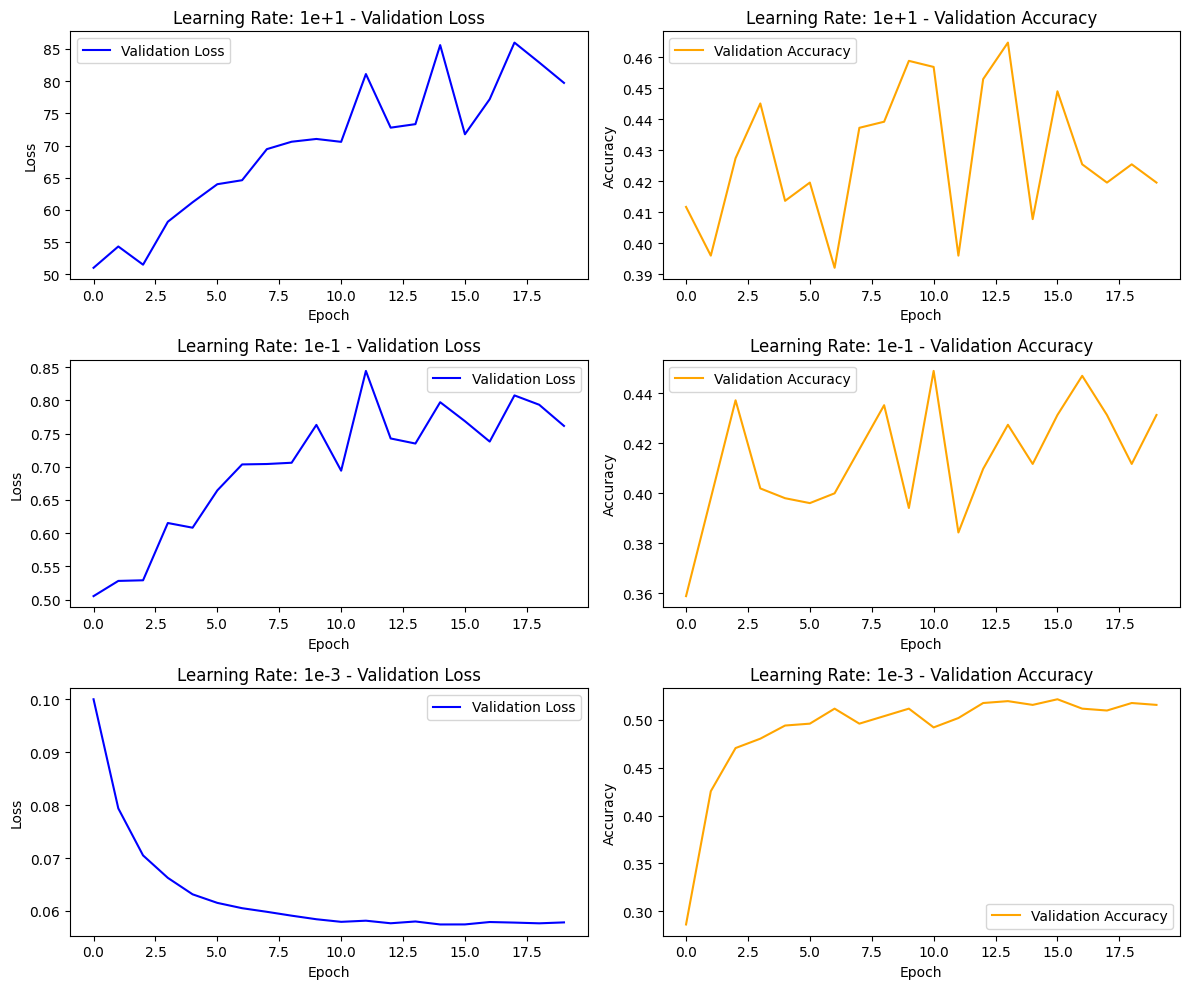

In [ ]:
def plot_training_progress(data_models, training_run_titles):
    metrics = ['val_loss', 'val_acc']
    metric_names = ['Validation Loss', 'Validation Accuracy']
    metric_colors = ['blue', 'orange']

    plt.figure(figsize=(12, 10))

    for i, (data, title) in enumerate(zip(data_models, training_run_titles)):
        for j, (metric, metric_name, color) in enumerate(zip(metrics, metric_names, metric_colors)):
            plt.subplot(3, 2, i * 2 + j + 1)
            plt.plot(data[metric], label=metric_name, color=color)
            plt.title(f'{title} - {metric_name}')
            plt.xlabel('Epoch')
            plt.ylabel(metric_name.split()[1])
            plt.legend()

    plt.tight_layout()
    plt.savefig('training_progress_early_fusion_base_lr_comparison.jpg', dpi=150)
    plt.show()

file_path_in_drive = "/content/gdrive/MyDrive/Masterarbeit/models/training_progress/EF_CH_1e+1.pkl"
local_file_path = '/content/EF_CH_1e+11.pkl'
shutil.copy(file_path_in_drive, local_file_path)
training_progress_data_model_1 = load_pickle_data(local_file_path)
training_run_title_1 = "Learning Rate: 1e+1"

file_path_in_drive = "/content/gdrive/MyDrive/Masterarbeit/models/training_progress/EF_CH_1e-1.pkl"
local_file_path = '/content/EF_CH_1e-1.pkl'
shutil.copy(file_path_in_drive, local_file_path)
training_progress_data_model_2 = load_pickle_data(local_file_path)
training_run_title_2 = "Learning Rate: 1e-1"

file_path_in_drive = "/content/gdrive/MyDrive/Masterarbeit/models/training_progress/EF_CH_1e-3.pkl"
local_file_path = '/content/EF_CH_1e-3.pkl'
shutil.copy(file_path_in_drive, local_file_path)
training_progress_data_model_3 = load_pickle_data(local_file_path)
training_run_title_3 = "Learning Rate: 1e-3"

plot_training_progress(
    [training_progress_data_model_1, training_progress_data_model_2, training_progress_data_model_3],
    [training_run_title_1, training_run_title_2, training_run_title_3]
)

In [ ]:
files.download('training_progress_early_fusion_base_lr_comparison.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>